<h1 align=center><font size = 7><em>The Battle of Neighborhoods</font></h1>

<h1 align=center><font size = 7><em>The Electric Vehicle City</font></h1>

## Introduction

This notebook is the study of the strategic locations of electric charging stations for the use of Electric vehicle charging around the city state of Singapore. Using the location data provided by Foursquare, an analysis of the city of Oslo, Norway and Singapore is done in comparison to identify ideal locations where such charging stations should be located. 

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Download and Explore Dataset</a>

2. <a href="#item2">Explore Neighborhoods in Oslo & Singapore</a>

3. <a href="#item3">Analyze Each Neighborhood</a>

4. <a href="#item4">Cluster Neighborhoods</a>
  
</font>
</div>

In [6]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Libraries imported.


# 1 Download and Explore Dataset

### 1.1 Data Cleaning

#### Import Car Data from Singapore

In [457]:
path='/Users/admin/Desktop/Capstone/sg.csv'
df_sg = pd.read_csv(path)
df_sg.head()

month category                       type  number
0  2016-12     Cars                     Petrol  578977
1  2016-12     Cars                     Diesel   10364
2  2016-12     Cars            Petrol-Electric   10075
3  2016-12     Cars  Petrol-Electric (Plug-In)     125
4  2016-12     Cars                 Petrol-CNG    1682

In [458]:
condition = (df_sg["category"] == 'Cars')
df_sg_cars = df_sg[condition]
df_sg_cars.head()

month category                       type  number
0  2016-12     Cars                     Petrol  578977
1  2016-12     Cars                     Diesel   10364
2  2016-12     Cars            Petrol-Electric   10075
3  2016-12     Cars  Petrol-Electric (Plug-In)     125
4  2016-12     Cars                 Petrol-CNG    1682

In [459]:
# Determining year of data
years = df_sg_cars["month"].unique().tolist()
years

['2016-12', '2017-12', '2018-01', '2018-02']

In [460]:
# Determining Type of Vecles
car_type = df_sg_cars["type"].unique().tolist()
car_type

['Petrol',
 'Diesel',
 'Petrol-Electric',
 'Petrol-Electric (Plug-In)',
 'Petrol-CNG',
 'CNG',
 'Electric',
 'Diesel-Electric']

### Next step is to Determine Sum of Electric Vehicles and Non-Electric Vehicles in Singapore

In [461]:
# non-electric
con_elec = (df_sg_cars["type"] == 'Petrol-Electric') | (df_sg_cars["type"] == 'Petrol-Electric (Plug-In)') | (df_sg_cars["type"] == 'Electric') | (df_sg_cars["type"] == 'Diesel-Electric')
df_sg_e = df_sg_cars[con_elec]

#non-electric
con_non_elec = (df_sg_cars["type"] == 'Petrol') | (df_sg_cars["type"] == 'Diesel') | (df_sg_cars["type"] == 'Petrol-CNG') | (df_sg_cars["type"] == 'CNG')
df_sg_non_e = df_sg_cars[con_non_elec]

sg_car = [['Country','Year','No. of Electric Cars','No. of Fossil Fuel Cars']]
c = 'Singapore'
years_selected = ['2016-12','2017-12','2018-02']
year_title = ['2016','2017','2018']

for t,year in zip(year_title,years_selected):
    
    #electric
    con1 = df_sg_e["month"] == year
    y_car_e = df_sg_e[con1]
    e_sum = y_car_e["number"].sum()
    
    #non-electric
    con2 = df_sg_non_e["month"] == year
    y_car_ne = df_sg_non_e[con2]
    non_e_sum = y_car_ne["number"].sum()
    
    table_info = [c,t,e_sum,non_e_sum]
    sg_car = np.append(sg_car,[table_info], axis=0)


#### Final Table of Singapore Cars

In [462]:
df_sgc = pd.DataFrame(sg_car,columns=['Country','Year','No. of Electric Cars','No. of Fossil Fuel Cars'])
df_sgc = df_sgc.drop(0,axis=0)
df_sgc

Country  Year No. of Electric Cars No. of Fossil Fuel Cars
1  Singapore  2016                10234                  591023
2  Singapore  2017                21293                  590963
3  Singapore  2018                21592                  589716

#### Import Car Data from Oslo, Norway

In [463]:
path2='/Users/admin/Desktop/Capstone/oslo.xlsx'
df_oslo = pd.read_excel(path2)
df_oslo.head()

11823: Registered vehicles, by region, type of fuel, contents and year  \
0                                                NaN                       
1                                                NaN                       
2                                                NaN                       
3                                            03 Oslo                       
4                                                NaN                       

  Unnamed: 1    Unnamed: 2  Unnamed: 3  Unnamed: 4  
0        NaN           NaN         NaN         NaN  
1        NaN  Private cars         NaN         NaN  
2        NaN          2016      2017.0      2018.0  
3     Petrol        129510    122675.0    115236.0  
4     Diesel        121287    110468.0    100061.0

In [464]:
# Remove the first 2 rows
df_oslo = df_oslo.drop([0,1,2],axis=0)

In [465]:
# Remove first 2 columns
df_oslo = df_oslo[["Unnamed: 1","Unnamed: 2","Unnamed: 3","Unnamed: 4"]]

In [466]:
df_oslo = df_oslo.rename(columns={"Unnamed: 1":"type","Unnamed: 2":"2016","Unnamed: 3":"2017","Unnamed: 4":"2018"})

In [467]:
df_oslo = df_oslo.reset_index()

In [468]:
# Remove index
df_oslo = df_oslo[["type","2016","2017","2018"]]

In [469]:
df_oslo

type    2016      2017      2018
0                          Petrol  129510  122675.0  115236.0
1                          Diesel  121287  110468.0  100061.0
2                        Paraffin       0       0.0       1.0
3                             Gas      40      31.0      12.0
4                     Electricity   16773   24808.0   36148.0
5                        Hydrogen      13      26.0      43.0
6       Petrol hybrid, chargeable   12518   23899.0   32898.0
7   Petrol hybrid, non-chargeable    6821    9246.0   10882.0
8       Diesel hybrid, chargeable    1197    2775.0    3535.0
9   Diesel hybrid, non-chargeable     142     117.0     121.0
10                     Other fuel      13      13.0      14.0

In [470]:
# electric
con_elec2 = (df_oslo["type"] == 'Petrol') | (df_oslo["type"] == 'Gas') | (df_oslo["type"] == 'Paraffin') | (df_oslo["type"] == 'Diesel') |(df_oslo["type"] == 'Hydrogen')|(df_oslo["type"] == 'Petrol hybrid, non-chargeable')|(df_oslo["type"] == 'Diesel hybrid, non-chargeable')|(df_oslo["type"] == 'Other fuel')
df_oslo_elec = df_oslo[con_elec2]

#non-electric
con_non_elec2 = (df_oslo["type"] == 'Electricity')|(df_oslo["type"] == 'Petrol hybrid, chargeable')|(df_oslo["type"] == 'Diesel hybrid, chargeable')
df_oslo_non_e = df_oslo[con_non_elec2]

### Next step is to Determine Sum of Electric Vehicles and Non-Electric Vehicles in Oslo

In [471]:
oslo_car = [['Country','Year','No. of Electric Cars','No. of Fossil Fuel Cars']]
o = 'Oslo'

year_title = ['2016','2017','2018']

for year in year_title:
    
    #electric
    con3 = df_oslo_elec[year]
    e_sum = con3.sum()
    
    #non-electric
    con4 = df_oslo_non_e[year]
    non_e_sum = con4.sum()
    
    table_info = [o,year,e_sum,non_e_sum]
    oslo_car = np.append(oslo_car,[table_info], axis=0)


In [472]:
oslo_car

array([['Country', 'Year', 'No. of Electric Cars',
        'No. of Fossil Fuel Cars'],
       ['Oslo', '2016', '257826', '30488'],
       ['Oslo', '2017', '242576.0', '51482.0'],
       ['Oslo', '2018', '226370.0', '72581.0']], dtype='<U23')

#### Final Table of Oslo Car

In [473]:
df_oc = pd.DataFrame(oslo_car,columns=['Country','Year','No. of Electric Cars','No. of Fossil Fuel Cars'])
df_oc = df_oc.drop(0,axis=0)

In [474]:
df_oc

Country  Year No. of Electric Cars No. of Fossil Fuel Cars
1    Oslo  2016               257826                   30488
2    Oslo  2017             242576.0                 51482.0
3    Oslo  2018             226370.0                 72581.0

#### Merge Table for Oslo & Singapore

In [475]:
df_sg_oslo = df_sgc.append(df_oc)

In [476]:
df_sg_oslo = df_sg_oslo.reset_index()

In [477]:
df_sg_oslo = df_sg_oslo[["Country","Year","No. of Electric Cars","No. of Fossil Fuel Cars"]]

In [478]:
df_sg_oslo = df_sg_oslo.astype({'Year': 'int32','No. of Electric Cars': 'float','No. of Fossil Fuel Cars': 'float'})

### 1.3 Exploratory Data Analysis

Based on definition of our problem, factors that will influence our decission are:
* number of existing petrol cars and electric cars there are both in Oslo, Norway as well as Singapore
* number of EV charging stations
* locations surrounding current EV Charging stations within Oslo
* clusters where EV charging stations can be placed in Singapore

Following data sources will be needed to extract/generate the required information:
* number of EV charging stations and their type and location surrounding every charging station will be obtained using **Foursquare API**
* coordinates of charging stations using **OpenStreetMap Nominatim: Search**

In [482]:

%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('fivethirtyeight') # optional: for ggplot-like style

In [483]:
df_sg_oslo

Country  Year  No. of Electric Cars  No. of Fossil Fuel Cars
0  Singapore  2016               10234.0                 591023.0
1  Singapore  2017               21293.0                 590963.0
2  Singapore  2018               21592.0                 589716.0
3       Oslo  2016              257826.0                  30488.0
4       Oslo  2017              242576.0                  51482.0
5       Oslo  2018              226370.0                  72581.0

#### Graph Plots of Car Population

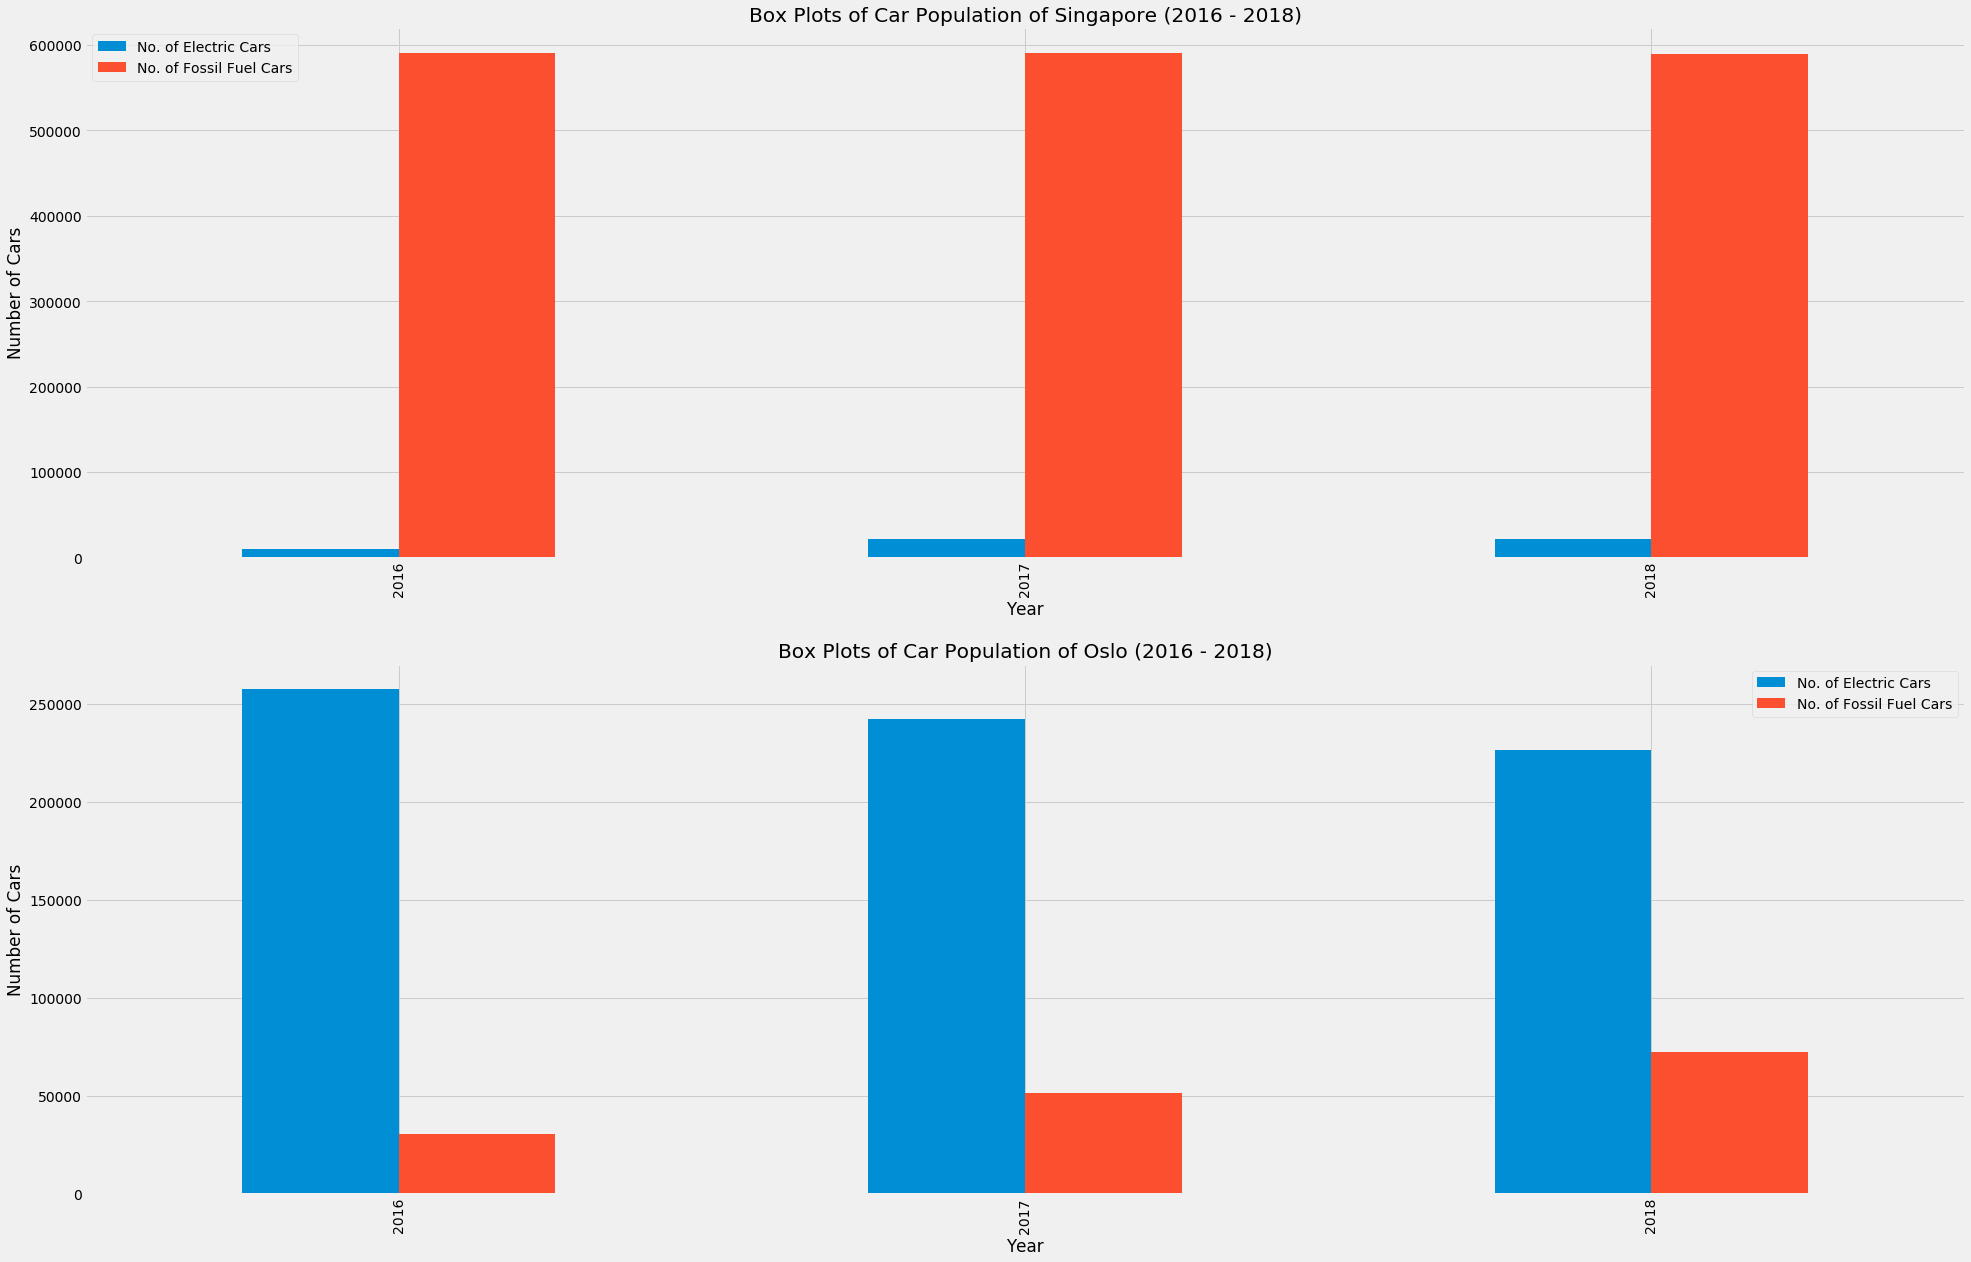

In [484]:
fig = plt.figure() # create figure

ax0 = fig.add_subplot(2, 1, 1) # add subplot 1 (2 row, 1 columns, first plot)
ax1 = fig.add_subplot(2, 1, 2) # add subplot 2 (2 row, 1 columns, second plot)

# Subplot 1: Singapore
df_sg_oslo[df_sg_oslo["Country"] == 'Singapore'].set_index('Year').plot(kind='bar', figsize=(30, 20), ax=ax0) # add to subplot 1
ax0.set_title('Box Plots of Car Population of Singapore (2016 - 2018)')
ax0.set_xlabel('Year')
ax0.set_ylabel('Number of Cars')

# Subplot 2: Line plot
df_sg_oslo[df_sg_oslo["Country"] == 'Oslo'].set_index('Year').plot(kind='bar', figsize=(30,20), ax=ax1) # add to subplot 1
ax1.set_title('Box Plots of Car Population of Oslo (2016 - 2018)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Cars')

plt.show()

# 2 Explore Neighbourhoods in Oslo & Singapore

## Path of Data

In [27]:
path = 'https://en.wikipedia.org/wiki/List_of_boroughs_of_Oslo'

## List of postal codes of Oslo, Norway

In [28]:
html = requests.get(path).content
pc_oslo_page = pd.read_html(html)

In [29]:
df_oslo_borough = pc_oslo_page[0]
df_oslo_borough

Borough Residents      Area  Number
0                Alna    45 114  13,7 km2      12
1              Bjerke    26 229   7,7 km2       9
2             Frogner    47 618   8,3 km2       5
3          Gamle Oslo    39 500   7,5 km2       1
4              Grorud    25 461   8,2 km2      10
5         Grünerløkka    42 129   4,8 km2       2
6         Nordre Aker    43 843  13,6 km2       8
7          Nordstrand    44 802  16,9 km2      14
8              Sagene    32 394   3,1 km2       3
9      St. Hanshaugen    30 144   3,6 km2       4
10            Stovner    29 351   8,2 km2      11
11  Søndre Nordstrand    34 980  18,4 km2      15
12             Ullern    28 898   9,4 km2       6
13        Vestre Aker    42 042  16,6 km2       7
14           Østensjø    44 399  12,2 km2      13

## EV Charging Station Oslo Dataframe

Based on Searches there are over 200 charging stations in Oslo

In [105]:
EV = ['Fortum Quick Charging Station',
      'Oslo kommune Charging Station1',
      'Oslo kommune Charging Station2',
      'Oslo kommune Charging Station3',
      'Oslo kommune Charging Station4',
      'Oslo kommune Charging Station5',
      'Oslo kommune Charging Station6',
      'Oslo kommune Charging Station7',
      'Oslo kommune Charging Station8',
      'Oslo kommune Charging Station9',
      'Oslo kommune Charging Station10',
      'Oslo kommune Charging Station11',
      'Oslo kommune Charging Station12',
      'Oslo kommune Charging Station13',
      'Oslo kommune Charging Station14',
      'Oslo kommune Charging Station15',
      'Oslo kommune Charging Station16',
      'Oslo kommune Charging Station17',
      'Oslo kommune Charging Station19',
      'Oslo kommune Charging Station20',
      'Oslo kommune Charging Station21',
      'Oslo kommune Charging Station22',
      'Oslo kommune Charging Station23',
      'Oslo kommune Charging Station24',
      'Oslo kommune Charging Station25',
      'Oslo kommune Charging Station26',
      'Oslo kommune Charging Station27',
      'Oslo kommune Charging Station28',
      'Oslo kommune Charging Station29',
      'Oslo kommune Charging Station30',
      'Oslo kommune Charging Station31',
      'Oslo kommune Charging Station32',
      'Oslo kommune Charging Station33',
      'Oslo kommune Charging Station34',
      'Oslo kommune Charging Station35',
      'Oslo kommune Charging Station36',
      'Oslo kommune Charging Station37',
      'Oslo kommune Charging Station38',
      'Oslo kommune Charging Station37',
      'Oslo kommune Charging Station39',
      'Oslo kommune Charging Station40',
      'Oslo kommune Charging Station41',
      'Oslo kommune Charging Station42',
      'Oslo kommune Charging Station43',
      'Oslo kommune Charging Station44',
      'Oslo kommune Charging Station45',
      'Oslo kommune Charging Station46',
      'Oslo kommune Charging Station47',
      'Oslo kommune Charging Station48',
      'Oslo kommune Charging Station49',
      'Oslo kommune Charging Station50',
      'Oslo kommune Charging Station51',
      'Oslo kommune Charging Station52',
      'Oslo kommune Charging Station53',
      'Oslo kommune Charging Station54',
      'Oslo kommune Charging Station55',
      'Oslo kommune Charging Station56',
      'Oslo kommune Charging Station57',
      'Oslo kommune Charging Station58',
      'Oslo kommune Charging Station59',
      'Oslo kommune Charging Station60',
      'Oslo kommune Charging Station61',
      'Oslo kommune Charging Station62',
      'Fortum Quick Charging Station2',
      'Fortum Quick Charging Station3',
      'Fortum Quick Charging Station4',
      'Fortum Quick Charging Station5',
      'Fortum Quick Charging Station6',
      'Fortum Quick Charging Station7',
      'Fortum Quick Charging Station8',
      'Fortum Quick Charging Station9',
      'Nobil Charging Station',
      'Nobil Charging Station2',
      'Nobil Charging Station3',
      'Nobil Charging Station4',
      'Nobil Charging Station5',
      'Nobil Charging Station6',
      'Nobil Charging Station7',
      'Nobil Charging Station8',
      'Nobil Charging Station9',
      'Nobil Charging Station10',
      'Nobil Charging Station11',
      'Nobil Charging Station12',
      'Nobil Charging Station13',
      'Nobil Charging Station14',
      'Nobil Charging Station15',
      'Nobil Charging Station16'
      
     ]

In [106]:
len(EV)

87

In [107]:
Address = ['Drammensveien 161B, 0277 Oslo, Norway',
           'Jens Bjelkes gate 14, 0562 Oslo, Norway',
           'Urtegata 11, 0187 Oslo, Norway',
           'Sørligata 10, 0577 Oslo, Norway',
           'Grønlandsleiret 15, 0190 Oslo, Norway',
           'Kjølberggata 27C, 0653 Oslo, Norway',
           'Telemarksvingen 21, 0655 Oslo, Norway',
           'Rolf Hofmos gate 23b, 0655 Oslo, Norway',
           'Kaare Røddes Plass, 0576 Oslo, Norway',
           'Bergljots vei 11, 0575 Oslo, Norway',
           'Alnafetgata 2, 0192 Oslo, Norway',
           'St. Jørgens vei, 0662 Oslo, Norway',
           'Svovelstikka 3, 0661 Oslo, Norway',
           'Karl Staaffs vei, 0665 Oslo, Norway',
           'Etterstadsletta 55, 0660 Oslo, Norway',
           'Vålerenggata 1, 0657 Oslo, Norway',
           'Hjaltlandsgata, 0658 Oslo, Norway',
           'Etterstadgata 5, 0658 Oslo, Norway',
           'Tokeruddalen, 0988 Oslo, Norway',
           'Rasmus Engers vei, 0956 Oslo, Norway',
           'Gangstuveien, 0952 Oslo, Norway',
           'Grevlingveien 5, 0595 Oslo, Norway',
           'Linderudveien 20, 0594 Oslo, Norway',
           'Hagapynten 13, 0673 Oslo, Norway',
           'Stjernemyrveien 36, 0673 Oslo, Norway',
           'Østensjøveien 64, 0668 Oslo, Norway',
           'Mekanikerveien 5, 0683 Oslo, Norway',
           'Havreveien 38, 0680 Oslo, Norway',
           'Bølerlia 22, 0691 Oslo, Norway',
           'Feltspatveien, 1155 Oslo, Norway',
           'Mikrobølgen 5, 1151 Oslo, Norway',
           'Refstad allé, 0586 Oslo, Norway',
           'Lørenveien 11, 0585 Oslo, Norway',
           'Grefsenveien 63, 0487 Oslo, Norway',
           'Kjelsåsveien 143, 0491 Oslo, Norway',
           'Nordstjerneveien, 0494 Oslo, Norway',
           'Nordkappgata 34, 0479 Oslo, Norway',
           'Knut Alvssons vei, 0574 Oslo, Norway',
           'Dynekilgata 4, 0569 Oslo, Norway',
           'Trondheimsveien 84, 0565 Oslo, Norway',
           'Sigrid Undsets vei 2, 0669 Oslo, Norway',
           'Ryenbergveien 52, 0196 Oslo, Norway',
           'Røhrts vei 35 A, 1181 Oslo, Norway',
           'Ekebergveien 109, 1178 Oslo, Norway',
           'Nedre Prinsdals vei 1, 1266 Oslo, Norway',
           'Badebakken 2, 0467 Oslo, Norway',
           'Sarpsborggata 1, 0468 Oslo, Norway',
           'Mogata 20B, 0464 Oslo, Norway',
           'Trøndergata 5, 0477 Oslo, Norway',
           'Krebs gate, 0478 Oslo, Norway',
           'Feddersens gate 3, 0473 Oslo, Norway',
           'Oskar Braatens gate 17, 0474 Oslo, Norway',
           'Biermanns gate 4, 0473 Oslo, Norway',
           'Vossegata 18, 0475 Oslo, Norway',
           'Dælenenggata 40A, 0567 Oslo, Norway',
           'Falsens gate, 0556 Oslo, Norway',
           'Seilduksgata 20, 0553 Oslo, Norway',
           'Gøteborggata 14, 0566 Oslo, Norway',
           'Sofienberggata 8, 0551 Oslo, Norway',
           'Kirkegårdsgata 1, 0558 Oslo, Norway',
           'Leirfallsgata, 0550 Oslo, Norway',
           'Trondheimsveien 7, 0569 Oslo, Norway',
           'Neuberggata 11, 0367 Oslo, Norway',
           'Klaus Torgårds vei 3, 0372 Oslo, Norway',
           'Thorvald Meyers gate 11, 0555 Oslo, Norway',
           'Monrads gate 13A, 0564 Oslo, Norway',
           'Strømsveien 241, 0668 Oslo, Norway',
           'Strømsveien 303, 1081 Oslo, Norway',
           'Mosseveien 147, 0198 Oslo, Norway',
           'Dalsåsen 4, 1285 Oslo, Norway',
           'Sognsvannsveien 21, 0372 Oslo, Norway',
           'Problemveien 13, 0371 Oslo, Norway',
           'Moldegata 9, 0468 Oslo, Norway',
           'Maridalsveien 29, 0175 Oslo, Norway',
           'Munkedamsveien 3B, 0161 Oslo, Norway',
           'Kongens gate, 0153 Oslo, Norway',
           'Sognsvannsveien 20, 0372 Oslo, Norway',
           'Sem Sælands vei, 0371 Oslo, Norway',
           'Eindrides vei 9, 0579 Oslo, Norway',
           'Kolstadgata 1, 0653 Oslo, Norway',
           'Borggata 4, 0650 Oslo, Norway',
           'Tøyenbekken 19, 1056 Oslo, Norway',
           'Hollendergata 5, 0190 Oslo, Norway',
           'Caspar Storms vei 14, 0664 Oslo, Norway',
           'Ole Deviks vei 2, 0666 Oslo, Norway',
           'Grenseveien 92, 0663 Oslo, Norway',
           'Biskop Jens Nilssøns gate 23B, 0659 Oslo, Norway' 
         
         ]

In [108]:
len(Address)

87

In [109]:
data = {'EV Station':EV, 'Address':Address}

In [110]:
df_oslo_EV = pd.DataFrame(data)

### Obtaining Latitude and Longitude of EV Charging Stations

In [112]:
ev_list=[['EV Station','Address','EV Station Latitude','EV Station Longitude']]

for name, add in zip(df_oslo_EV['EV Station'],df_oslo_EV['Address']):
        geolocator = Nominatim(user_agent="oslo_explorer")
        location = geolocator.geocode(add)
        lat = location.latitude
        long = location.longitude
         
        entry = [name,add,lat,long]
        ev_list = np.append(ev_list,[entry], axis=0)   

In [113]:
EV_lat_lon = ev_list

In [114]:
EV_lat_lon

array([['EV Station', 'Address', 'EV Station Latitude',
        'EV Station Longitude'],
       ['Fortum Quick Charging Station',
        'Drammensveien 161B, 0277 Oslo, Norway', '59.9222341',
        '10.6752676334115'],
       ['Oslo kommune Charging Station1',
        'Jens Bjelkes gate 14, 0562 Oslo, Norway', '59.91844',
        '10.7650364'],
       ['Oslo kommune Charging Station2',
        'Urtegata 11, 0187 Oslo, Norway', '59.914975', '10.763885'],
       ['Oslo kommune Charging Station3',
        'Sørligata 10, 0577 Oslo, Norway', '59.9143058', '10.7723994'],
       ['Oslo kommune Charging Station4',
        'Grønlandsleiret 15, 0190 Oslo, Norway', '59.912256',
        '10.764388'],
       ['Oslo kommune Charging Station5',
        'Kjølberggata 27C, 0653 Oslo, Norway', '59.912301', '10.777729'],
       ['Oslo kommune Charging Station6',
        'Telemarksvingen 21, 0655 Oslo, Norway', '59.913489',
        '10.784178'],
       ['Oslo kommune Charging Station7',
        'Rolf H

In [115]:
df_EV = pd.DataFrame(EV_lat_lon,columns=['EV Station', 'Address', 'EV Station Latitude','EV Station Longitude'])
df_EV = df_EV.drop(0,axis=0)

In [116]:
df_EV.set_index('EV Station')

Address  \
EV Station                                                                          
Fortum Quick Charging Station               Drammensveien 161B, 0277 Oslo, Norway   
Oslo kommune Charging Station1            Jens Bjelkes gate 14, 0562 Oslo, Norway   
Oslo kommune Charging Station2                     Urtegata 11, 0187 Oslo, Norway   
Oslo kommune Charging Station3                    Sørligata 10, 0577 Oslo, Norway   
Oslo kommune Charging Station4              Grønlandsleiret 15, 0190 Oslo, Norway   
Oslo kommune Charging Station5                Kjølberggata 27C, 0653 Oslo, Norway   
Oslo kommune Charging Station6              Telemarksvingen 21, 0655 Oslo, Norway   
Oslo kommune Charging Station7            Rolf Hofmos gate 23b, 0655 Oslo, Norway   
Oslo kommune Charging Station8              Kaare Røddes Plass, 0576 Oslo, Norway   
Oslo kommune Charging Station9                Bergljots vei 11, 0575 Oslo, Norway   
Oslo kommune Charging Station10                  Alnafetgata 2, 0192 Oslo, Norway   
Oslo kommune Charging Station11                St. Jørgens vei, 0662 Oslo, Norway   
Oslo kommune Charging Station12                 Svovelstikka 3, 0661 Oslo, Norway   
Oslo kommune Charging Station13               Karl Staaffs vei, 0665 Oslo, Norway   
Oslo kommune Charging Station14             Etterstadsletta 55, 0660 Oslo, Norway   
Oslo kommune Charging Station15                 Vålerenggata 1, 0657 Oslo, Norway   
Oslo kommune Charging Station16                 Hjaltlandsgata, 0658 Oslo, Norway   
Oslo kommune Charging Station17                Etterstadgata 5, 0658 Oslo, Norway   
Oslo kommune Charging Station19                   Tokeruddalen, 0988 Oslo, Norway   
Oslo kommune Charging Station20              Rasmus Engers vei, 0956 Oslo, Norway   
Oslo kommune Charging Station21                   Gangstuveien, 0952 Oslo, Norway   
Oslo kommune Charging Station22                Grevlingveien 5, 0595 Oslo, Norway   
Oslo kommune Charging Station23               Linderudveien 20, 0594 Oslo, Norway   
Oslo kommune Charging Station24                  Hagapynten 13, 0673 Oslo, Norway   
Oslo kommune Charging Station25             Stjernemyrveien 36, 0673 Oslo, Norway   
Oslo kommune Charging Station26               Østensjøveien 64, 0668 Oslo, Norway   
Oslo kommune Charging Station27               Mekanikerveien 5, 0683 Oslo, Norway   
Oslo kommune Charging Station28                  Havreveien 38, 0680 Oslo, Norway   
Oslo kommune Charging Station29                    Bølerlia 22, 0691 Oslo, Norway   
Oslo kommune Charging Station30                  Feltspatveien, 1155 Oslo, Norway   
Oslo kommune Charging Station31                  Mikrobølgen 5, 1151 Oslo, Norway   
Oslo kommune Charging Station32                   Refstad allé, 0586 Oslo, Norway   
Oslo kommune Charging Station33                  Lørenveien 11, 0585 Oslo, Norway   
Oslo kommune Charging Station34                Grefsenveien 63, 0487 Oslo, Norway   
Oslo kommune Charging Station35               Kjelsåsveien 143, 0491 Oslo, Norway   
Oslo kommune Charging Station36               Nordstjerneveien, 0494 Oslo, Norway   
Oslo kommune Charging Station37                Nordkappgata 34, 0479 Oslo, Norway   
Oslo kommune Charging Station38              Knut Alvssons vei, 0574 Oslo, Norway   
Oslo kommune Charging Station37                  Dynekilgata 4, 0569 Oslo, Norway   
Oslo kommune Charging Station39             Trondheimsveien 84, 0565 Oslo, Norway   
Oslo kommune Charging Station40           Sigrid Undsets vei 2, 0669 Oslo, Norway   
Oslo kommune Charging Station41               Ryenbergveien 52, 0196 Oslo, Norway   
Oslo kommune Charging Station42                Røhrts vei 35 A, 1181 Oslo, Norway   
Oslo kommune Charging Station43               Ekebergveien 109, 1178 Oslo, Norway   
Oslo kommune Charging Station44          Nedre Prinsdals vei 1, 1266 Oslo, Norway   
Oslo kommune Charging Station45                   Badebakken 2, 0467 Oslo, Norw

In [117]:
df_EV = df_EV.astype({'EV Station Latitude': 'float','EV Station Longitude': 'float'})

In [118]:
CLIENT_ID = 'DL5JBLYTPFZTQM0ZHOT4PM4EF3NKRL52GAPIF5US5BOIKOTV'
CLIENT_SECRET = 'RYYZ1MPATEPOIQUEMI55U0ZJ2CGDKMKV5LSDCMKBLAJWH0W0'
VERSION = '20180604'
LIMIT = 15
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: DL5JBLYTPFZTQM0ZHOT4PM4EF3NKRL52GAPIF5US5BOIKOTV
CLIENT_SECRET:RYYZ1MPATEPOIQUEMI55U0ZJ2CGDKMKV5LSDCMKBLAJWH0W0


## Searching for Venues Surrounding EV Charging Stations in Oslo

### Get top venues that are in Neighbourhoods in Oslo within a radius of 500 meters.

In [122]:
def getNearbyVenues(names,address, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name,add, lat, lng in zip(names,address, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            add,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['EV Station', 
                  'Address', 
                  'EV Station Latitude', 
                  'EV Station Longitude',
                  'Venue Name',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [123]:
oslo_venues = getNearbyVenues(names=df_EV['EV Station'],address=df_EV['Address'],
                                   latitudes=df_EV['EV Station Latitude'],
                                   longitudes=df_EV['EV Station Longitude']
                                  )

Fortum Quick Charging Station
Oslo kommune Charging Station1
Oslo kommune Charging Station2
Oslo kommune Charging Station3
Oslo kommune Charging Station4
Oslo kommune Charging Station5
Oslo kommune Charging Station6
Oslo kommune Charging Station7
Oslo kommune Charging Station8
Oslo kommune Charging Station9
Oslo kommune Charging Station10
Oslo kommune Charging Station11
Oslo kommune Charging Station12
Oslo kommune Charging Station13
Oslo kommune Charging Station14
Oslo kommune Charging Station15
Oslo kommune Charging Station16
Oslo kommune Charging Station17
Oslo kommune Charging Station19
Oslo kommune Charging Station20
Oslo kommune Charging Station21
Oslo kommune Charging Station22
Oslo kommune Charging Station23
Oslo kommune Charging Station24
Oslo kommune Charging Station25
Oslo kommune Charging Station26
Oslo kommune Charging Station27
Oslo kommune Charging Station28
Oslo kommune Charging Station29
Oslo kommune Charging Station30
Oslo kommune Charging Station31
Oslo kommune Chargi

In [124]:
oslo_venues.head()

EV Station                                Address  \
0  Fortum Quick Charging Station  Drammensveien 161B, 0277 Oslo, Norway   
1  Fortum Quick Charging Station  Drammensveien 161B, 0277 Oslo, Norway   
2  Fortum Quick Charging Station  Drammensveien 161B, 0277 Oslo, Norway   
3  Fortum Quick Charging Station  Drammensveien 161B, 0277 Oslo, Norway   
4  Fortum Quick Charging Station  Drammensveien 161B, 0277 Oslo, Norway   

   EV Station Latitude  EV Station Longitude            Venue Name  \
0            59.922234             10.675268  Maschmanns Matmarked   
1            59.922234             10.675268           Olsens Enke   
2            59.922234             10.675268    QUI Taste of Italy   
3            59.922234             10.675268     Coop Mega Sjølyst   
4            59.922234             10.675268       Kaffebrenneriet   

   Venue Latitude  Venue Longitude      Venue Category  
0       59.921541        10.680131        Gourmet Shop  
1       59.923067        10.669753         Flower Shop  
2       59.921633        10.679149  Italian Restaurant  
3       59.921236        10.677899              Market  
4       59.920393        10.683442         Coffee Shop

## Mapping Oslo, Norway Venues around EV Charging Station

In [125]:
address = 'Oslo, Norway'

geolocator = Nominatim(user_agent="oslo_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Oslo are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Oslo are 59.9133301, 10.7389701.


In [126]:
# create map of Manhattan using latitude and longitude values
map_oslo = folium.Map(location=[latitude, longitude], zoom_start=13)


# add markers to map
for lat, lng, label in zip(oslo_venues['Venue Latitude'], oslo_venues['Venue Longitude'], oslo_venues['Venue Category']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_oslo)  

for lat2, lng2, label2 in zip(oslo_venues['EV Station Latitude'], oslo_venues['EV Station Longitude'],oslo_venues['EV Station']):
    label2 = folium.Popup(label2, parse_html=True)
    folium.CircleMarker(
        [lat2, lng2],
        radius=5,
        popup=label2,
        color='red',
        fill=True,
        fill_opacity=0.7,
        parse_html=False).add_to(map_oslo) 
    
map_oslo

## Analyse Each EV Charging Station Area in Oslo

In [127]:
#crete a copy of venues
o_ev = oslo_venues.copy()
o_ev.head()

EV Station                                Address  \
0  Fortum Quick Charging Station  Drammensveien 161B, 0277 Oslo, Norway   
1  Fortum Quick Charging Station  Drammensveien 161B, 0277 Oslo, Norway   
2  Fortum Quick Charging Station  Drammensveien 161B, 0277 Oslo, Norway   
3  Fortum Quick Charging Station  Drammensveien 161B, 0277 Oslo, Norway   
4  Fortum Quick Charging Station  Drammensveien 161B, 0277 Oslo, Norway   

   EV Station Latitude  EV Station Longitude            Venue Name  \
0            59.922234             10.675268  Maschmanns Matmarked   
1            59.922234             10.675268           Olsens Enke   
2            59.922234             10.675268    QUI Taste of Italy   
3            59.922234             10.675268     Coop Mega Sjølyst   
4            59.922234             10.675268       Kaffebrenneriet   

   Venue Latitude  Venue Longitude      Venue Category  
0       59.921541        10.680131        Gourmet Shop  
1       59.923067        10.669753         Flower Shop  
2       59.921633        10.679149  Italian Restaurant  
3       59.921236        10.677899              Market  
4       59.920393        10.683442         Coffee Shop

In [128]:
venue_count = o_ev.groupby('EV Station').count()
venue_count = venue_count['Address']

In [129]:
venue_count = pd.DataFrame(venue_count)

In [130]:
venue_count.rename(columns={0 : "No. Venue"})

Address
EV Station                              
Fortum Quick Charging Station         15
Fortum Quick Charging Station2        12
Fortum Quick Charging Station3        15
Fortum Quick Charging Station4        15
Fortum Quick Charging Station5        15
Fortum Quick Charging Station6         9
Fortum Quick Charging Station7         4
Fortum Quick Charging Station8         4
Fortum Quick Charging Station9         5
Nobil Charging Station                15
Nobil Charging Station10              15
Nobil Charging Station11              15
Nobil Charging Station12              15
Nobil Charging Station13               4
Nobil Charging Station14               5
Nobil Charging Station15              15
Nobil Charging Station16               8
Nobil Charging Station2               10
Nobil Charging Station3               15
Nobil Charging Station4               15
Nobil Charging Station5               15
Nobil Charging Station6                4
Nobil Charging Station7               11
Nobil Charging Station8                9
Nobil Charging Station9               15
Oslo kommune Charging Station1        15
Oslo kommune Charging Station10        6
Oslo kommune Charging Station11       12
Oslo kommune Charging Station12       14
Oslo kommune Charging Station13        7
Oslo kommune Charging Station14        6
Oslo kommune Charging Station15       15
Oslo kommune Charging Station16       15
Oslo kommune Charging Station17       14
Oslo kommune Charging Station19        5
Oslo kommune Charging Station2        15
Oslo kommune Charging Station20        1
Oslo kommune Charging Station21        4
Oslo kommune Charging Station22        5
Oslo kommune Charging Station23        7
Oslo kommune Charging Station24        4
Oslo kommune Charging Station25        5
Oslo kommune Charging Station27        6
Oslo kommune Charging Station28        7
Oslo kommune Charging Station29        6
Oslo kommune Charging Station3        15
Oslo kommune Charging Station30        4
Oslo kommune Charging Station31        7
Oslo kommune Charging Station32        7
Oslo kommune Charging Station33       15
Oslo kommune Charging Station34       15
Oslo kommune Charging Station35       10
Oslo kommune Charging Station36        5
Oslo kommune Charging Station37       30
Oslo kommune Charging Station38       15
Oslo kommune Charging Station39       15
Oslo kommune Charging Station4        15
Oslo kommune Charging Station40        8
Oslo kommune Charging Station41        5
Oslo kommune Charging Station42        5
Oslo kommune Charging Station43        3
Oslo kommune Charging Station44        6
Oslo kommune Charging Station45       15
Oslo kommune Charging Station46       15
Oslo kommune Charging Station47       15
Oslo kommune Charging Station48       15
Oslo kommune Charging Station49       15
Oslo kommune Charging Station5        15
Oslo kommune Charging Station50       15
Oslo kommune Charging Station51       15
Oslo kommune Charging Station52       15
Oslo kommune Charging Station53       15
Oslo kommune Charging Station54       15
Oslo kommune Charging Station55       15
Oslo kommune Charging Station56       15
Oslo kommune Charging Station57       15
Oslo kommune Charging Station58       15
Oslo kommune Charging Station59       15
Oslo kommune Charging Station6        15
Oslo kommune Charging Station60       15
Oslo kommune Charging Station61       15
Oslo kommune Charging Station62       15
Oslo kommune Charging Station7        12
Oslo kommune Charging Station8        10
Oslo kommune Charging Station9        13

In [131]:
# one hot encoding
oslo_onehot = pd.get_dummies(o_ev[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
oslo_onehot['EV Station'] = o_ev['EV Station']

# move neighborhood column to the first column
cols = oslo_onehot.columns.tolist()
cols.remove('EV Station')
cols[0]='EV Station'
oslo_onehot = oslo_onehot[cols]

oslo_onehot.head()

EV Station  Arcade  Art Museum  Arts & Crafts Store  \
0  Fortum Quick Charging Station       0           0                    0   
1  Fortum Quick Charging Station       0           0                    0   
2  Fortum Quick Charging Station       0           0                    0   
3  Fortum Quick Charging Station       0           0                    0   
4  Fortum Quick Charging Station       0           0                    0   

   Asian Restaurant  Athletics & Sports  Auto Workshop  Automotive Shop  \
0                 0                   0              0                0   
1                 0                   0              0                0   
2                 0                   0              0                0   
3                 0                   0              0                0   
4                 0                   0              0                0   

   BBQ Joint  Bakery  Bar  Bathing Area  Beach  Beer Bar  Beer Garden  \
0          0       0    0             0      0         0            0   
1          0       0    0             0      0         0            0   
2          0       0    0             0      0         0            0   
3          0       0    0             0      0         0            0   
4          0       0    0             0      0         0            0   

   Beer Store  Bike Shop  Bistro  Boat or Ferry  Bookstore  Botanical Garden  \
0           0          0       0              0          0                 0   
1           0          0       0              0          0                 0   
2           0          0       0              0          0                 0   
3           0          0       0              0          0                 0   
4           0          0       0              0          0                 0   

   Bowling Alley  Breakfast Spot  Brewery  Burger Joint  Bus Station  \
0              0               0        0             0            0   
1              0               0        0             0            0   
2              0               0        0             0            0   
3              0               0        0             0            0   
4              0               0        0             0            0   

   Bus Stop  Business Service  Cafeteria  Café  Camera Store  Campground  \
0         0                 0          0     0             0           0   
1         0                 0          0     0             0           0   
2         0                 0          0     0             0           0   
3         0                 0          0     0             0           0   
4         0                 0          0     0             0           0   

   Chinese Restaurant  Climbing Gym  Clothing Store  Cocktail Bar  \
0                   0             0               0             0   
1                   0             0               0             0   
2                   0             0               0             0   
3                   0             0               0             0   
4                   0             0               0             0   

   Coffee Shop  College Administrative Building  College Cafeteria  \
0            0                                0                  0   
1            0                                0                  0   
2            0                                0                  0   
3            0                                0                  0   
4            1                                0                  0   

   Comfort Food Restaurant  Community Center  Concert Hall  Convenience Store  \
0                        0                 0             0                  0   
1                        0                 0             0                  0   
2                        0                 0             0                  0   
3                        0                 0             0                  0   
4                        0                 0             

## Grouping EV Station by Each Category

In [132]:
oslo_grouped = oslo_onehot.groupby('EV Station').mean().reset_index()
oslo_grouped.head()

EV Station  Arcade  Art Museum  Arts & Crafts Store  \
0   Fortum Quick Charging Station     0.0    0.000000             0.000000   
1  Fortum Quick Charging Station2     0.0    0.000000             0.000000   
2  Fortum Quick Charging Station3     0.0    0.000000             0.000000   
3  Fortum Quick Charging Station4     0.0    0.066667             0.000000   
4  Fortum Quick Charging Station5     0.0    0.000000             0.066667   

   Asian Restaurant  Athletics & Sports  Auto Workshop  Automotive Shop  \
0               0.0                 0.0            0.0         0.000000   
1               0.0                 0.0            0.0         0.000000   
2               0.0                 0.0            0.0         0.000000   
3               0.0                 0.0            0.0         0.000000   
4               0.0                 0.0            0.0         0.066667   

   BBQ Joint    Bakery       Bar  Bathing Area  Beach  Beer Bar  Beer Garden  \
0        0.0  0.000000  0.000000           0.0    0.0       0.0     0.000000   
1        0.0  0.000000  0.000000           0.0    0.0       0.0     0.000000   
2        0.0  0.000000  0.066667           0.0    0.0       0.0     0.066667   
3        0.0  0.066667  0.066667           0.0    0.0       0.0     0.000000   
4        0.0  0.000000  0.000000           0.0    0.0       0.0     0.000000   

   Beer Store  Bike Shop  Bistro  Boat or Ferry  Bookstore  Botanical Garden  \
0         0.0   0.000000     0.0            0.0        0.0          0.000000   
1         0.0   0.083333     0.0            0.0        0.0          0.000000   
2         0.0   0.000000     0.0            0.0        0.0          0.000000   
3         0.0   0.000000     0.0            0.0        0.0          0.133333   
4         0.0   0.000000     0.0            0.0        0.0          0.000000   

   Bowling Alley  Breakfast Spot  Brewery  Burger Joint  Bus Station  \
0            0.0             0.0      0.0           0.0     0.000000   
1            0.0             0.0      0.0           0.0     0.083333   
2            0.0             0.0      0.0           0.0     0.000000   
3            0.0             0.0      0.0           0.0     0.000000   
4            0.0             0.0      0.0           0.0     0.133333   

   Bus Stop  Business Service  Cafeteria      Café  Camera Store  Campground  \
0       0.0               0.0        0.0  0.000000           0.0         0.0   
1       0.0               0.0        0.0  0.000000           0.0         0.0   
2       0.0               0.0        0.0  0.066667           0.0         0.0   
3       0.0               0.0        0.0  0.000000           0.0         0.0   
4       0.0               0.0        0.0  0.000000           0.0         0.0   

   Chinese Restaurant  Climbing Gym  Clothing Store  Cocktail Bar  \
0            0.000000           0.0             0.0      0.000000   
1            0.000000           0.0             0.0      0.000000   
2            0.000000           0.0             0.0      0.000000   
3            0.066667           0.0             0.0      0.066667   
4            0.000000           0.0             0.0      0.000000   

   Coffee Shop  College Administrative Building  College Cafeteria  \
0     0.200000                              0.0                0.0   
1     0.083333                              0.0                0.0   
2     0.066667                              0.0                0.0   
3     0.000000                              0.0                0.0   
4     0.000000                              0.0                0.0   

   Comfort Food Restaurant  Community Center  Concert Hall  Convenience Store  \
0                      0.0               0.0           0.0                0.0   
1                      0.0               0.0           0.0                0.0   
2                      0.0               0.0           0.0                0.0   
3                      0.0               0.0           0.0         

### Determining each EV Station's top 10 most common venues

In [133]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [134]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['EV Station']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
oslo_venues_sorted = pd.DataFrame(columns=columns)
oslo_venues_sorted['EV Station'] = oslo_grouped['EV Station']

for ind in np.arange(oslo_grouped.shape[0]):
    oslo_venues_sorted.iloc[ind, 1:] = return_most_common_venues(oslo_grouped.iloc[ind, :], num_top_venues)

oslo_venues_sorted.head()

EV Station 1st Most Common Venue 2nd Most Common Venue  \
0   Fortum Quick Charging Station           Coffee Shop                Market   
1  Fortum Quick Charging Station2           Coffee Shop             Bike Shop   
2  Fortum Quick Charging Station3  Gym / Fitness Center            Restaurant   
3  Fortum Quick Charging Station4      Botanical Garden                  Park   
4  Fortum Quick Charging Station5     Electronics Store           Bus Station   

    3rd Most Common Venue 4th Most Common Venue      5th Most Common Venue  \
0             Flower Shop    Italian Restaurant       Other Great Outdoors   
1           Grocery Store         Metro Station       Fast Food Restaurant   
2                    Café         Grocery Store                Coffee Shop   
3          Science Museum                Garden  Middle Eastern Restaurant   
4  Furniture / Home Store           Supermarket            Automotive Shop   

           6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0                  Train Station             Juice Bar     Electronics Store   
1              Electronics Store              Pharmacy           Pizza Place   
2                  Movie Theater     Indian Restaurant     French Restaurant   
3             Chinese Restaurant                   Bar                Bakery   
4  Paper / Office Supplies Store    Spanish Restaurant   Sporting Goods Shop   

  9th Most Common Venue 10th Most Common Venue  
0                 Hotel           Gourmet Shop  
1           Bus Station            Supermarket  
2                   Bar            Pizza Place  
3           Music Venue           Cocktail Bar  
4         Grocery Store    Arts & Crafts Store

### List of Venues in EV Station

In [135]:
col = oslo_venues_sorted.columns.tolist()
col_header = col[1:]

In [136]:
oslo_venues_sorted['List of Top Venues'] = oslo_venues_sorted[col_header].values.tolist()

In [137]:
oslo_venues_list = oslo_venues_sorted[['EV Station','List of Top Venues']]

In [138]:
oslo_venues_list = oslo_venues_list.set_index('EV Station')

In [139]:
for index, row in oslo_venues_list.iterrows():
    a = oslo_venues_list['List of Top Venues'].loc[index]
    oslo_venues_list.loc[index] = ', '.join(a)

In [ ]:
oslo_venues_list.head()

# 3 Cluster Neighborhoods

In [141]:
# Venues around EV Stations
o_ev.head()

EV Station                                Address  \
0  Fortum Quick Charging Station  Drammensveien 161B, 0277 Oslo, Norway   
1  Fortum Quick Charging Station  Drammensveien 161B, 0277 Oslo, Norway   
2  Fortum Quick Charging Station  Drammensveien 161B, 0277 Oslo, Norway   
3  Fortum Quick Charging Station  Drammensveien 161B, 0277 Oslo, Norway   
4  Fortum Quick Charging Station  Drammensveien 161B, 0277 Oslo, Norway   

   EV Station Latitude  EV Station Longitude            Venue Name  \
0            59.922234             10.675268  Maschmanns Matmarked   
1            59.922234             10.675268           Olsens Enke   
2            59.922234             10.675268    QUI Taste of Italy   
3            59.922234             10.675268     Coop Mega Sjølyst   
4            59.922234             10.675268       Kaffebrenneriet   

   Venue Latitude  Venue Longitude      Venue Category  
0       59.921541        10.680131        Gourmet Shop  
1       59.923067        10.669753         Flower Shop  
2       59.921633        10.679149  Italian Restaurant  
3       59.921236        10.677899              Market  
4       59.920393        10.683442         Coffee Shop

In [142]:
# EV Stations
df_EV

EV Station  \
1     Fortum Quick Charging Station   
2    Oslo kommune Charging Station1   
3    Oslo kommune Charging Station2   
4    Oslo kommune Charging Station3   
5    Oslo kommune Charging Station4   
6    Oslo kommune Charging Station5   
7    Oslo kommune Charging Station6   
8    Oslo kommune Charging Station7   
9    Oslo kommune Charging Station8   
10   Oslo kommune Charging Station9   
11  Oslo kommune Charging Station10   
12  Oslo kommune Charging Station11   
13  Oslo kommune Charging Station12   
14  Oslo kommune Charging Station13   
15  Oslo kommune Charging Station14   
16  Oslo kommune Charging Station15   
17  Oslo kommune Charging Station16   
18  Oslo kommune Charging Station17   
19  Oslo kommune Charging Station19   
20  Oslo kommune Charging Station20   
21  Oslo kommune Charging Station21   
22  Oslo kommune Charging Station22   
23  Oslo kommune Charging Station23   
24  Oslo kommune Charging Station24   
25  Oslo kommune Charging Station25   
26  Oslo kommune Charging Station26   
27  Oslo kommune Charging Station27   
28  Oslo kommune Charging Station28   
29  Oslo kommune Charging Station29   
30  Oslo kommune Charging Station30   
31  Oslo kommune Charging Station31   
32  Oslo kommune Charging Station32   
33  Oslo kommune Charging Station33   
34  Oslo kommune Charging Station34   
35  Oslo kommune Charging Station35   
36  Oslo kommune Charging Station36   
37  Oslo kommune Charging Station37   
38  Oslo kommune Charging Station38   
39  Oslo kommune Charging Station37   
40  Oslo kommune Charging Station39   
41  Oslo kommune Charging Station40   
42  Oslo kommune Charging Station41   
43  Oslo kommune Charging Station42   
44  Oslo kommune Charging Station43   
45  Oslo kommune Charging Station44   
46  Oslo kommune Charging Station45   
47  Oslo kommune Charging Station46   
48  Oslo kommune Charging Station47   
49  Oslo kommune Charging Station48   
50  Oslo kommune Charging Station49   
51  Oslo kommune Charging Station50   
52  Oslo kommune Charging Station51   
53  Oslo kommune Charging Station52   
54  Oslo kommune Charging Station53   
55  Oslo kommune Charging Station54   
56  Oslo kommune Charging Station55   
57  Oslo kommune Charging Station56   
58  Oslo kommune Charging Station57   
59  Oslo kommune Charging Station58   
60  Oslo kommune Charging Station59   
61  Oslo kommune Charging Station60   
62  Oslo kommune Charging Station61   
63  Oslo kommune Charging Station62   
64   Fortum Quick Charging Station2   
65   Fortum Quick Charging Station3   
66   Fortum Quick Charging Station4   
67   Fortum Quick Charging Station5   
68   Fortum Quick Charging Station6   
69   Fortum Quick Charging Station7   
70   Fortum Quick Charging Station8   
71   Fortum Quick Charging Station9   
72           Nobil Charging Station   
73          Nobil Charging Station2   
74          Nobil Charging Station3   
75          Nobil Charging Station4   
76          Nobil Charging Station5   
77          Nobil Charging Station6   
78          Nobil Charging Station7   
79          Nobil Charging Station8   
80          Nobil Charging Station9   
81         Nobil Charging Station10   
82         Nobil Charging Station11   
83         Nobil Charging Station12   
84         Nobil Charging Station13   
85         Nobil Charging Station14   
86         Nobil Charging Station15   
87         Nobil Charging Station16   

                                             Address  EV Station Latitude  \
1              Drammensveien 161B, 0277 Oslo, Norway            59.922234   
2            Jens Bjelkes gate 14, 0562 Oslo, Norway            59.918440   
3                     Urtegata 11, 0187 Oslo, Norway            59.914975   
4                    Sørligata 10, 0577 Oslo, Norway            59.914306   
5              Grønlandsleiret 15, 0190 Oslo, Norway            59.912256   
6                Kjølberggata 27C, 0653 Oslo, Norway            59.912301   
7              Telemarksvingen 21, 0655 Oslo, Norway 

In [143]:
# set number of clusters
kclusters = 5

oslo_grouped_clustering = oslo_grouped.drop('EV Station', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(oslo_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 3, 2, 1, 0, 2, 0, 3], dtype=int32)

In [144]:
kmeans.labels_

array([0, 0, 0, 3, 2, 1, 0, 2, 0, 3, 3, 3, 3, 2, 2, 2, 1, 3, 3, 0, 0, 2,
       3, 1, 3, 0, 0, 1, 2, 1, 1, 0, 0, 1, 1, 3, 4, 1, 2, 0, 2, 2, 2, 1,
       1, 3, 1, 2, 2, 1, 1, 1, 1, 1, 1, 0, 3, 2, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 3, 3, 3, 0, 1, 0, 1, 1, 1],
      dtype=int32)

## Insert Cluster Labels to EV Stations

In [145]:
# add clustering labels
oslo_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [146]:
oslo_venues_sorted.head()

Cluster Labels                      EV Station 1st Most Common Venue  \
0               0   Fortum Quick Charging Station           Coffee Shop   
1               0  Fortum Quick Charging Station2           Coffee Shop   
2               0  Fortum Quick Charging Station3  Gym / Fitness Center   
3               3  Fortum Quick Charging Station4      Botanical Garden   
4               2  Fortum Quick Charging Station5     Electronics Store   

  2nd Most Common Venue   3rd Most Common Venue 4th Most Common Venue  \
0                Market             Flower Shop    Italian Restaurant   
1             Bike Shop           Grocery Store         Metro Station   
2            Restaurant                    Café         Grocery Store   
3                  Park          Science Museum                Garden   
4           Bus Station  Furniture / Home Store           Supermarket   

       5th Most Common Venue          6th Most Common Venue  \
0       Other Great Outdoors                  Train Station   
1       Fast Food Restaurant              Electronics Store   
2                Coffee Shop                  Movie Theater   
3  Middle Eastern Restaurant             Chinese Restaurant   
4            Automotive Shop  Paper / Office Supplies Store   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0             Juice Bar     Electronics Store                 Hotel   
1              Pharmacy           Pizza Place           Bus Station   
2     Indian Restaurant     French Restaurant                   Bar   
3                   Bar                Bakery           Music Venue   
4    Spanish Restaurant   Sporting Goods Shop         Grocery Store   

  10th Most Common Venue                                 List of Top Venues  
0           Gourmet Shop  [Coffee Shop, Market, Flower Shop, Italian Res...  
1            Supermarket  [Coffee Shop, Bike Shop, Grocery Store, Metro ...  
2            Pizza Place  [Gym / Fitness Center, Restaurant, Café, Groce...  
3           Cocktail Bar  [Botanical Garden, Park, Science Museum, Garde...  
4    Arts & Crafts Store  [Electronics Store, Bus Station, Furniture / H...

In [147]:
oslo_EV_clusters = df_EV

In [148]:
# merge data to obtain latitude and longitude
oslo_EV_clusters = oslo_EV_clusters.join(oslo_venues_sorted.set_index('EV Station'), on='EV Station')

In [149]:
oslo_EV_clusters.head()

EV Station                                  Address  \
1   Fortum Quick Charging Station    Drammensveien 161B, 0277 Oslo, Norway   
2  Oslo kommune Charging Station1  Jens Bjelkes gate 14, 0562 Oslo, Norway   
3  Oslo kommune Charging Station2           Urtegata 11, 0187 Oslo, Norway   
4  Oslo kommune Charging Station3          Sørligata 10, 0577 Oslo, Norway   
5  Oslo kommune Charging Station4    Grønlandsleiret 15, 0190 Oslo, Norway   

   EV Station Latitude  EV Station Longitude  Cluster Labels  \
1            59.922234             10.675268             0.0   
2            59.918440             10.765036             0.0   
3            59.914975             10.763885             3.0   
4            59.914306             10.772399             3.0   
5            59.912256             10.764388             3.0   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
1           Coffee Shop                Market           Flower Shop   
2      Tapas Restaurant           Yoga Studio    Italian Restaurant   
3                   Bar     Indian Restaurant           Yoga Studio   
4     Indian Restaurant                Bakery                   Bar   
5                   Bar     Indian Restaurant           Coffee Shop   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
1    Italian Restaurant  Other Great Outdoors         Train Station   
2          Cocktail Bar                  Café                  Park   
3   Dumpling Restaurant                  Café                Bistro   
4       Thai Restaurant            Art Museum           Coffee Shop   
5   Dumpling Restaurant                   Gym         Grocery Store   

     7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
1                Juice Bar     Electronics Store                 Hotel   
2                  Brewery           Music Store     French Restaurant   
3                     Park            Beer Store           Beer Garden   
4      Dumpling Restaurant    Turkish Restaurant                Bistro   
5  Scandinavian Restaurant                Bistro                  Café   

      10th Most Common Venue  \
1               Gourmet Shop   
2  Middle Eastern Restaurant   
3                    Brewery   
4           Sushi Restaurant   
5                 Beer Store   

                                  List of Top Venues  
1  [Coffee Shop, Market, Flower Shop, Italian Res...  
2  [Tapas Restaurant, Yoga Studio, Italian Restau...  
3  [Bar, Indian Restaurant, Yoga Studio, Dumpling...  
4  [Indian Restaurant, Bakery, Bar, Thai Restaura...  
5  [Bar, Indian Restaurant, Coffee Shop, Dumpling...

In [154]:
oslo_EV_clusters.dropna(subset=["Cluster Labels"], axis=0, inplace=True)

In [155]:
oslo_EV_clusters['Cluster Labels'] = oslo_EV_clusters['Cluster Labels'].astype(int)

## Visualising the Cluster

In [156]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []

for lat, lon, poi, cluster in zip(oslo_EV_clusters['EV Station Latitude'], oslo_EV_clusters['EV Station Longitude'], oslo_EV_clusters['EV Station'], oslo_EV_clusters['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Alternative Visualisation Method

The Yellow Markers are the EV Charging Stations while the other colours are the clusters they are in

In [157]:
# add clustering labels
#oslo_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

oslo_merged = o_ev[['EV Station','Venue Name','Venue Latitude','Venue Longitude','Venue Category']]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
oslo_merged = oslo_merged.join(oslo_venues_sorted[['EV Station','Cluster Labels']].set_index('EV Station'), on='EV Station')

oslo_merged.head() 

EV Station            Venue Name  Venue Latitude  \
0  Fortum Quick Charging Station  Maschmanns Matmarked       59.921541   
1  Fortum Quick Charging Station           Olsens Enke       59.923067   
2  Fortum Quick Charging Station    QUI Taste of Italy       59.921633   
3  Fortum Quick Charging Station     Coop Mega Sjølyst       59.921236   
4  Fortum Quick Charging Station       Kaffebrenneriet       59.920393   

   Venue Longitude      Venue Category  Cluster Labels  
0        10.680131        Gourmet Shop               0  
1        10.669753         Flower Shop               0  
2        10.679149  Italian Restaurant               0  
3        10.677899              Market               0  
4        10.683442         Coffee Shop               0

In [158]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(oslo_merged['Venue Latitude'], oslo_merged['Venue Longitude'], oslo_merged['Venue Category'], oslo_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
for lat2, lng2, label2 in zip(oslo_EV_clusters['EV Station Latitude'], oslo_EV_clusters['EV Station Longitude'],oslo_EV_clusters['EV Station']):
    label2 = folium.Popup(label2, parse_html=True)
    folium.CircleMarker(
        [lat2, lng2],
        radius=5,
        popup=label2,
        color='yellow',
        fill=True,
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters)         

map_clusters

## Cluster Analysis

## Cluster 0

In [159]:
zero = oslo_EV_clusters.loc[oslo_EV_clusters['Cluster Labels'] == 0, oslo_EV_clusters.columns[[0] + list(range(4, oslo_EV_clusters.shape[1]))]]

In [160]:
zero

EV Station  Cluster Labels 1st Most Common Venue  \
1     Fortum Quick Charging Station               0           Coffee Shop   
2    Oslo kommune Charging Station1               0      Tapas Restaurant   
11  Oslo kommune Charging Station10               0           Coffee Shop   
16  Oslo kommune Charging Station15               0          Hockey Arena   
17  Oslo kommune Charging Station16               0                  Park   
23  Oslo kommune Charging Station23               0                  Café   
40  Oslo kommune Charging Station39               0           Yoga Studio   
42  Oslo kommune Charging Station41               0                  Café   
43  Oslo kommune Charging Station42               0                  Café   
44  Oslo kommune Charging Station43               0    Athletics & Sports   
47  Oslo kommune Charging Station46               0         Deli / Bodega   
48  Oslo kommune Charging Station47               0                  Park   
49  Oslo kommune Charging Station48               0                  Park   
50  Oslo kommune Charging Station49               0          Cocktail Bar   
51  Oslo kommune Charging Station50               0                  Park   
52  Oslo kommune Charging Station51               0           Coffee Shop   
53  Oslo kommune Charging Station52               0                  Café   
54  Oslo kommune Charging Station53               0                  Café   
55  Oslo kommune Charging Station54               0           Coffee Shop   
56  Oslo kommune Charging Station55               0                  Café   
58  Oslo kommune Charging Station57               0                  Café   
61  Oslo kommune Charging Station60               0      Tapas Restaurant   
63  Oslo kommune Charging Station62               0                   Pub   
64   Fortum Quick Charging Station2               0           Coffee Shop   
65   Fortum Quick Charging Station3               0  Gym / Fitness Center   
69   Fortum Quick Charging Station7               0                 Beach   
71   Fortum Quick Charging Station9               0  Fast Food Restaurant   
75          Nobil Charging Station4               0                 Plaza   
76          Nobil Charging Station5               0        Clothing Store   

   2nd Most Common Venue 3rd Most Common Venue        4th Most Common Venue  \
1                 Market           Flower Shop           Italian Restaurant   
2            Yoga Studio    Italian Restaurant                 Cocktail Bar   
11                 Plaza                  Park                         Café   
16                  Park            Sports Bar                Grocery Store   
17          Hockey Arena            Sports Bar                Grocery Store   
23     Convenience Store         Bowling Alley                         Park   
40               Theater         Grocery Store  Eastern European Restaurant   
42           Pizza Place           Coffee Shop                  Flower Shop   
43                  Park           Bus Station                 Soccer Field   
44        Soccer Stadium          Soccer Field                  Yoga Studio   
47        Breakfast Spot                Bakery                 Dessert Shop   
48         Deli / Bodega           Coffee Shop                   Restaurant   
49            Restaurant          Climbing Gym             Sushi Restaurant   
50       Thai Restaurant             Wine Shop                        Diner   
51          Cocktail Bar       Thai Restaurant            Indian Restaurant   
52            Restaurant      Sushi Restaurant               History Museum   
53                   Gym                   Bar         Gym / Fitness Center   
54           Coffee Shop                  Park                        Diner   
55               Theater         Grocery Store            Indian Restaurant   
56           Coffee Shop     French Restaurant                Movie Theater   
58           Yoga Studio               Theater         

Cluster zero is made of venues that are meant for sports activities such as Gym, Soccer Field and Athletics & Sports. This cluster are also surrounded with a wide varitey of bars, cafes and restaurants. The charging station is strategically place to serve the needs of Gym goers and those who do sports.

## Cluster 1

In [161]:
one = oslo_EV_clusters.loc[oslo_EV_clusters['Cluster Labels'] == 1, oslo_EV_clusters.columns[[0] + list(range(4, oslo_EV_clusters.shape[1]))]]

In [162]:
one

EV Station  Cluster Labels 1st Most Common Venue  \
8    Oslo kommune Charging Station7               1         Grocery Store   
9    Oslo kommune Charging Station8               1          Soccer Field   
10   Oslo kommune Charging Station9               1         Grocery Store   
12  Oslo kommune Charging Station11               1         Grocery Store   
14  Oslo kommune Charging Station13               1        Soccer Stadium   
15  Oslo kommune Charging Station14               1         Grocery Store   
18  Oslo kommune Charging Station17               1         Grocery Store   
19  Oslo kommune Charging Station19               1  Fast Food Restaurant   
21  Oslo kommune Charging Station21               1              Gym Pool   
28  Oslo kommune Charging Station28               1             Wine Shop   
29  Oslo kommune Charging Station29               1         Shopping Mall   
30  Oslo kommune Charging Station30               1         Grocery Store   
33  Oslo kommune Charging Station33               1         Grocery Store   
34  Oslo kommune Charging Station34               1         Grocery Store   
35  Oslo kommune Charging Station35               1         Grocery Store   
36  Oslo kommune Charging Station36               1         Grocery Store   
37  Oslo kommune Charging Station37               1         Grocery Store   
38  Oslo kommune Charging Station38               1         Grocery Store   
39  Oslo kommune Charging Station37               1         Grocery Store   
45  Oslo kommune Charging Station44               1  Gym / Fitness Center   
46  Oslo kommune Charging Station45               1         Grocery Store   
62  Oslo kommune Charging Station61               1  Gym / Fitness Center   
68   Fortum Quick Charging Station6               1        Soccer Stadium   
79          Nobil Charging Station8               1         Grocery Store   
87         Nobil Charging Station16               1         Grocery Store   

   2nd Most Common Venue 3rd Most Common Venue   4th Most Common Venue  \
8           Hockey Arena                   Bar             Pizza Place   
9                    Gym            Water Park        Asian Restaurant   
10          Dance Studio             Wine Shop            Soccer Field   
12  Fast Food Restaurant           Bus Station                Bus Stop   
14           Music Venue  Gym / Fitness Center           Grocery Store   
15           Coffee Shop             Dive Shop                  Bakery   
18          Hockey Arena                   Bar               Gastropub   
19      Department Store         Grocery Store        Video Game Store   
21      Asian Restaurant         Grocery Store    Fast Food Restaurant   
28      Asian Restaurant  Gym / Fitness Center             Bus Station   
29              Gym Pool         Grocery Store             Supermarket   
30                 Track              Gym Pool             Yoga Studio   
33           Coffee Shop     Indian Restaurant        Sushi Restaurant   
34  Gym / Fitness Center    Light Rail Station     Sporting Goods Shop   
35        Science Museum      Department Store             Bus Station   
36    Light Rail Station      Department Store           Deli / Bodega   
37  Gym / Fitness Center                  Park                    Café   
38              Bus Stop  Gym / Fitness Center    Fast Food Restaurant   
39  Gym / Fitness Center                  Park                    Café   
45         Train Station         Grocery Store       Convenience Store   
46      Sushi Restaurant                Bakery             Coffee Shop   
62         Grocery Store      Sushi Restaurant  Furniture / Home Store   
68           Music Venue          Skating Rink             Bus Station   
79          Soccer Field            Water Park        Asian Restaurant   
87                  Park           Pizza Place              Sports Bar   

          5th Most Common Venue        6th Most Common Venue  \
8                          Café  

Cluster 1 has the 1st common venue for all charging stations in the cluster as Grocery stores. The EV stations there are strategically placed for commuters who enter these cluster locations for grocerries.

## Cluster 2

In [163]:
two = oslo_EV_clusters.loc[oslo_EV_clusters['Cluster Labels'] == 2, oslo_EV_clusters.columns[[0] + list(range(4, oslo_EV_clusters.shape[1]))]]

In [164]:
two

EV Station  Cluster Labels   1st Most Common Venue  \
13  Oslo kommune Charging Station12               2             Bus Station   
22  Oslo kommune Charging Station22               2  Furniture / Home Store   
24  Oslo kommune Charging Station24               2       Electronics Store   
25  Oslo kommune Charging Station25               2                     Gym   
27  Oslo kommune Charging Station27               2           Metro Station   
31  Oslo kommune Charging Station31               2           Shopping Mall   
32  Oslo kommune Charging Station32               2             Bus Station   
41  Oslo kommune Charging Station40               2           Metro Station   
67   Fortum Quick Charging Station5               2       Electronics Store   
70   Fortum Quick Charging Station8               2           Shopping Mall   
77          Nobil Charging Station6               2             Bus Station   
84         Nobil Charging Station13               2                  Arcade   
85         Nobil Charging Station14               2       Convenience Store   
86         Nobil Charging Station15               2             Bus Station   

   2nd Most Common Venue   3rd Most Common Venue 4th Most Common Venue  \
13           Coffee Shop       Convenience Store         Grocery Store   
22          Home Service             Bus Station         Metro Station   
24                   Gym             Bus Station           Supermarket   
25         Grocery Store             Bus Station         Shopping Mall   
27               Stadium             Supermarket         Grocery Store   
31           Bus Station           Grocery Store    Athletics & Sports   
32             Racetrack           Grocery Store    Chinese Restaurant   
41          Camera Store       Convenience Store         Grocery Store   
67           Bus Station  Furniture / Home Store           Supermarket   
70           Bus Station           Metro Station           Yoga Studio   
77         Metro Station             Snack Place          Tram Station   
84             Racetrack  Thrift / Vintage Store           Bus Station   
85         Grocery Store             Bus Station         Metro Station   
86           Coffee Shop                  Bakery        Soccer Stadium   

     5th Most Common Venue          6th Most Common Venue  \
13                  Bakery              Food & Drink Shop   
22                Beer Bar                    Yoga Studio   
24            Dessert Shop    Eastern European Restaurant   
25           Metro Station                    Yoga Studio   
27       Martial Arts Dojo                          Diner   
31             Flower Shop                   Soccer Field   
32                    Café                    Yoga Studio   
41        Video Game Store                           Café   
67         Automotive Shop  Paper / Office Supplies Store   
70            Dessert Shop    Eastern European Restaurant   
77             Yoga Studio                   Dessert Shop   
84            Dessert Shop    Eastern European Restaurant   
85  Thrift / Vintage Store                    Yoga Studio   
86        Sushi Restaurant           Fast Food Restaurant   

   7th Most Common Venue        8th Most Common Venue 9th Most Common Venue  \
13         Metro Station             Sushi Restaurant             Gastropub   
22     Electronics Store  Eastern European Restaurant   Dumpling Restaurant   
24   Dumpling Restaurant                      Dog Run             Dive Shop   
25          Dessert Shop          Dumpling Restaurant               Dog Run   
27     Electronics Store  Eastern European Restaurant   Dumpling Restaurant   
31         Metro Station                 Dessert Shop               Dog Run   
32          Dessert Shop          Dumpling Restaurant               Dog Run   
41          Dessert Shop  Eastern European Restaurant   Dumpling Restaurant   
67    Spanish Restaurant          Sporting Goods Shop         Grocery Store   
70   Dumpling Restaura

Cluster two is located close to Bus stations and metros. Surrounding this convenient and accescible locations are food and beverage establishments, malls and areas of leisurely activity. These areas will see high daily traffic as such drivers with EV can conveiently charge their vehicle whilst running errands or shopping.

## Cluster 3

In [165]:
three = oslo_EV_clusters.loc[oslo_EV_clusters['Cluster Labels'] == 3, oslo_EV_clusters.columns[[0] + list(range(4, oslo_EV_clusters.shape[1]))]]

In [166]:
three

EV Station  Cluster Labels 1st Most Common Venue  \
3    Oslo kommune Charging Station2               3                   Bar   
4    Oslo kommune Charging Station3               3     Indian Restaurant   
5    Oslo kommune Charging Station4               3                   Bar   
6    Oslo kommune Charging Station5               3                   Bar   
7    Oslo kommune Charging Station6               3                   Bar   
57  Oslo kommune Charging Station56               3                  Café   
59  Oslo kommune Charging Station58               3           Coffee Shop   
60  Oslo kommune Charging Station59               3           Coffee Shop   
66   Fortum Quick Charging Station4               3      Botanical Garden   
72           Nobil Charging Station               3                   Bar   
73          Nobil Charging Station2               3      Sushi Restaurant   
74          Nobil Charging Station3               3                   Bar   
78          Nobil Charging Station7               3      Ramen Restaurant   
80          Nobil Charging Station9               3                   Bar   
81         Nobil Charging Station10               3                   Bar   
82         Nobil Charging Station11               3     Indian Restaurant   
83         Nobil Charging Station12               3                   Bar   

      2nd Most Common Venue 3rd Most Common Venue  4th Most Common Venue  \
3         Indian Restaurant           Yoga Studio    Dumpling Restaurant   
4                    Bakery                   Bar        Thai Restaurant   
5         Indian Restaurant           Coffee Shop    Dumpling Restaurant   
6                    Bakery                  Park           Burger Joint   
7                      Café  Gym / Fitness Center        Thai Restaurant   
57                      Bar         Movie Theater                    Pub   
59             Burger Joint    Italian Restaurant  Performing Arts Venue   
60                      Bar                Bakery               Creperie   
66                     Park        Science Museum                 Garden   
72            Metro Station     College Cafeteria                    Pub   
73                   Bakery           Fish Market           Soccer Field   
74  Comfort Food Restaurant          Noodle House       Tapas Restaurant   
78                   Bakery        Soccer Stadium           Soccer Field   
80        Indian Restaurant                Bakery                   Park   
81              Coffee Shop     Indian Restaurant               Wine Bar   
82                      Bar           Coffee Shop             Food Truck   
83              Coffee Shop     Indian Restaurant             Beer Store   

              5th Most Common Venue 6th Most Common Venue  \
3                              Café                Bistro   
4                        Art Museum           Coffee Shop   
5                               Gym         Grocery Store   
6                  Sushi Restaurant                  Food   
7                       Coffee Shop         Grocery Store   
57                    Grocery Store     Indian Restaurant   
59                              Pub    Salon / Barbershop   
60                     Cocktail Bar                  Café   
66        Middle Eastern Restaurant    Chinese Restaurant   
72  College Administrative Building                 Plaza   
73                             Park                   Bar   
74                             Café    Seafood Restaurant   
78                        Bookstore    Mexican Restaurant   
80                  Thai Restaurant            Art Museum   
81                              Gym   Dumpling Restaurant   
82             Gym / Fitness Center                   Gym   
83                         Wine Bar                   Gym   

      7th Most Common Venue 8th Most Common Venue    9th Most Common Venue  \
3                      Park            Beer Store              Beer Garden   
4       Dumpli

Cluster 3 is a location filled with with varity of food and beverage establishments. These are areas people visit for meals and gatherings. Strategically EV charging stations can serve commuters needs as they frequent such cluster locations.

## Cluster 4

In [167]:
four = zero = oslo_EV_clusters.loc[oslo_EV_clusters['Cluster Labels'] == 4, oslo_EV_clusters.columns[[0] + list(range(4, oslo_EV_clusters.shape[1]))]]

In [168]:
four

EV Station  Cluster Labels 1st Most Common Venue  \
20  Oslo kommune Charging Station20               4          Soccer Field   

   2nd Most Common Venue 3rd Most Common Venue        4th Most Common Venue  \
20           Yoga Studio        Farmers Market  Eastern European Restaurant   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
20   Dumpling Restaurant               Dog Run             Dive Shop   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  \
20                 Diner          Dessert Shop       Department Store   

                                   List of Top Venues  
20  [Soccer Field, Yoga Studio, Farmers Market, Ea...

Cluster 4 has a single station which serves primarily the crowds that go to the soccer stadium. Since games are hosted on weekends the peak periods are presumably on weekends as such a single station should suffice the neghbourhoods needs. Grocery store shoppers who live in that area have the station to deepend on as well.

# List of neighbourhoods of Singapore

## Central List

In [224]:
path3='/Users/admin/Desktop/Capstone/c_n.csv'
central = pd.read_csv(path3)

In [225]:
central.head()

Neighbour
0      Bishan East
1        Marymount
2    Upper Thomson
3   Alexandra Hill
4  Alexandra North

In [226]:
# EV_lat_lon_sg= get_EV_lat_lon(df_oslo_EV['EV Station'], df_oslo_EV['Address'])

In [228]:
    central_list=[['Neighbourhoods','Latitude','Longitude']]
    for add in central['Neighbour']:

            geolocator = Nominatim(user_agent="singapore_explorer")
            location = geolocator.geocode(add)
            latitude = location.latitude
            longitude = location.longitude
         
            entry = [add,latitude,longitude]
            central_list = np.append(central_list,[entry], axis=0)   

In [229]:
central_list

array([['Neighbourhoods', 'Latitude', 'Longitude'],
       ['Bishan East', '1.3514521', '103.8482496'],
       ['Marymount', '53.0426727', '-7.78637348586453'],
       ['Upper Thomson', '1.354498', '103.832820550675'],
       ['Alexandra Hill', '34.5780844', '32.9790375'],
       ['Alexandra North', '51.2062799', '6.7772213'],
       ['Bukit Ho Swee', '1.2879953', '103.828564415084'],
       ['Depot Road', '-43.3043009', '172.1651377'],
       ['Everton Park', '-27.4064443', '152.9869559'],
       ['Henderson Hill', '42.7645081', '-77.6827759'],
       ['Kampong Tiong Bahru', '1.2859869', '103.8276042'],
       ['Redhill', '51.2404691', '-0.1682816'],
       ['Singapore General Hospital', '1.27944885', '103.836280497274'],
       ['Telok Blangah Drive', '1.2727476', '103.8094655'],
       ['Telok Blangah Rise', '1.2733393', '103.8206709'],
       ['Telok Blangah Way', '1.2775976', '103.8177703'],
       ['Tiong Bahru', '1.2861968', '103.8257646'],
       ['Tiong Bahru Station', '1.2861

In [346]:
df_central = pd.DataFrame(central_list,columns=['Neighbourhoods','Latitude','Longitude'])
df_central = df_central.drop(0,axis=0)

In [347]:
df_central.head()

Neighbourhoods    Latitude          Longitude
1      Bishan East   1.3514521        103.8482496
2        Marymount  53.0426727  -7.78637348586453
3    Upper Thomson    1.354498   103.832820550675
4   Alexandra Hill  34.5780844         32.9790375
5  Alexandra North  51.2062799          6.7772213

In [355]:
df_central = df_central.drop(1,axis=0)

## East

In [249]:
path4='/Users/admin/Desktop/Capstone/e_n.csv'
east = pd.read_csv(path4)

In [270]:
east.head()

Neighbour
0         Bayshore
1      Bedok North
2  Bedok Reservoir
3      Bedok South
4          Frankel

In [250]:
    east_list=[['Neighbourhoods','Latitude','Longitude']]
    for add in east['Neighbour']:

            geolocator = Nominatim(user_agent="singapore_explorer")
            location = geolocator.geocode(add)
            latitude = location.latitude
            longitude = location.longitude
         
            entry = [add,latitude,longitude]
            east_list = np.append(east_list,[entry], axis=0) 

In [251]:
df_east = pd.DataFrame(east_list,columns=['Neighbourhoods','Latitude','Longitude'])
df_east = df_east.drop(0,axis=0)

In [252]:
df_east.head()

Neighbourhoods    Latitude         Longitude
1         Bayshore   25.828986       -80.1853251
2      Bedok North   1.3324018       103.9193052
3  Bedok Reservoir   1.3425058  103.925229807312
4      Bedok South   1.3170871       103.9499069
5          Frankel  49.5303998  8.86232064556016

## North-East

In [272]:
path5='/Users/admin/Desktop/Capstone/ne_n.csv'
north_east = pd.read_csv(path5)

In [274]:
north_east.head()

Neighbour
0  Ang Mo Kio Town Centre
1               Cheng San
2              Chong Boon
3             Kebun Baru 
4         Sembawang Hills

In [275]:
    n_east_list=[['Neighbourhoods','Latitude','Longitude']]
    for add in north_east['Neighbour']:

            geolocator = Nominatim(user_agent="singapore_explorer")
            location = geolocator.geocode(add)
            latitude = location.latitude
            longitude = location.longitude
         
            entry = [add,latitude,longitude]
            n_east_list = np.append(n_east_list,[entry], axis=0) 

In [276]:
df_n_east = pd.DataFrame(n_east_list,columns=['Neighbourhoods','Latitude','Longitude'])
df_n_east = df_n_east.drop(0,axis=0)

In [277]:
df_n_east

Neighbourhoods     Latitude         Longitude
1   Ang Mo Kio Town Centre     1.369842       103.8466086
2                Cheng San   35.6951591       139.7559133
3               Chong Boon   1.36820695  103.856360356937
4              Kebun Baru     2.4545231        96.4307499
5          Sembawang Hills    1.3723986    103.8290294792
6               Shangri-La    28.055698         99.849049
7                  Tagore     10.848047       106.7724049
8               Townsville  -19.2569391       146.8239537
9             Yio Chu Kang    1.3587904       103.8742217
10       Yio Chu Kang East    1.3587904       103.8742217
11     Yio Chu Kang North     1.3587904       103.8742217
12       Yio Chu Kang West    1.3587904       103.8742217
13    Defu Industrial Park   1.35161105      103.89204505
14         Hougang Central    1.3712907       103.8907556
15            Hougang East    1.3733601       103.8860907
16            Hougang West    1.3733601       103.8860907
17                 Kangkar    1.3839216       103.9022015
18                  Kovan    50.4233074        14.7777673
19           Lorong Ah Soo    1.3520481       103.8845867
20           Lorong Halus     1.3831229        103.922492
21               Tai Seng     1.3387694       103.8906378
22               Trafalgar   45.1644528       -62.5561578
23            Coney Island    40.575789        -73.985145
24                 Matilda   29.8846493       -91.6040029
25              Northshore   44.0409378       -88.5165427
26           Punggol Canal     1.398033       103.9073312
27           Punggol Field    1.3930598       103.9137421
28     Punggol Town Centre     1.398033       103.9073312
29           Waterway East      5.97116       125.2867816
30     Pulau Punggol Barat    1.4251234       103.8789977
31     Pulau Punggol Timor    1.4198936       103.8904904
32                Seletar     1.4098488       103.8773789
33  Seletar Aerospace Park    1.4050713       103.8647976
34             Anchorvale    1.38927895  103.887639999679
35            Compassvale      1.394518       103.9004349
36               Fernvale    42.7784516       -123.371454
37     Lorong Halus North     1.3831229        103.922492
38              Rivervale    41.0095418         -74.01125
39    Sengkang Town Centre    1.3909487       103.8951748
40          Sengkang West     1.3909487       103.8951748
41            Lorong Chuan    1.3541321       103.8651253
42           Seletar Hills    1.3854637       103.8656683
43       Serangoon Central    1.3475734       103.8748122
44        Serangoon Garden    1.3624579       103.8660127
45         Serangoon North    1.3713383       103.8727563
46        Upper Paya Lebar    1.3538993  103.887820526624

## North

In [176]:
path6='/Users/admin/Desktop/Capstone/n_n.csv'
north = pd.read_csv(path6)

In [177]:
    n_list=[['Neighbourhoods','Latitude','Longitude']]
    for add in north['Neighbour']:

            geolocator = Nominatim(user_agent="singapore_explorer")
            location = geolocator.geocode(add)
            latitude = location.latitude
            longitude = location.longitude
         
            entry = [add,latitude,longitude]
            n_list = np.append(n_list,[entry], axis=0) 

In [178]:
df_n = pd.DataFrame(n_list,columns=['Neighbourhoods','Latitude','Longitude'])
df_n = df_n.drop(0,axis=0)

In [179]:
df_n.head()

Neighbourhoods     Latitude          Longitude
1        Mandai East   23.8673152   91.4555832919795
2      Mandai Estate    1.4080529        103.7588873
3        Mandai West   23.8673152   91.4555832919795
4          Admiralty  40.70221515  -73.2655858764612
5  Sembawang Central    1.1264172        112.2514274

## West

In [189]:
path7='/Users/admin/Desktop/Capstone/w_n.csv'
west = pd.read_csv(path7)

In [279]:
    w_list=[['Neighbourhoods','Latitude','Longitude']]
    for add in west['Neighbour']:

            geolocator = Nominatim(user_agent="singapore_explorer")
            location = geolocator.geocode(add)
            latitude = location.latitude
            longitude = location.longitude
         
            entry = [add,latitude,longitude]
            w_list = np.append(w_list,[entry], axis=0) 

In [278]:
west.head()

Neighbour
0  Boon Lay
1  Liu Fang
2   Samulun
3  Shipyard
4    Tukang

In [280]:
df_w = pd.DataFrame(w_list,columns=['Neighbourhoods','Latitude','Longitude'])
df_w = df_w.drop(0,axis=0)

In [281]:
df_w.head()

Neighbourhoods    Latitude         Longitude
1       Boon Lay   1.3456401       103.7118018
2       Liu Fang  32.2541722       117.2842662
3        Samulun    1.302728  103.697428262079
4       Shipyard  38.1548868  14.7747077620005
5         Tukang  -7.3055955       110.5704391

## Final Singapore List

In [356]:
df_sgt=pd.DataFrame()

In [357]:
df_sgt = df_sgt.append(df_central)

In [358]:
df_sgt = df_sgt.append(df_east)

In [359]:
df_sgt = df_sgt.append(df_n_east)

In [360]:
df_sgt = df_sgt.append(df_n)

In [361]:
df_sgt.head()

Neighbourhoods    Latitude          Longitude
2        Marymount  53.0426727  -7.78637348586453
3    Upper Thomson    1.354498   103.832820550675
4   Alexandra Hill  34.5780844         32.9790375
5  Alexandra North  51.2062799          6.7772213
6    Bukit Ho Swee   1.2879953   103.828564415084

### Current EV Charging Stations Singapore

In Singapore there are currently 24 EV stations

In [82]:
EV_sg = ['Zeco Systems',
         'BlueSG1',
         'BlueSG2',
         'BlueSG3',
         'BYD Charging Station',
         'HDT EV charging stations',
         'BlueSG4',
         'BlueSG5',
         'BlueSG7',
         'BlueSG8',
         'BlueSG9',
         'Gift of Power@City Square',
         'BlueSG10',
         'BlueSG11',
         'BlueSG13',
         'BlueSG14',
         'BlueSG15',
         'BlueSG16',
         'BlueSG17',
         'BlueSG18',
         'BlueSG19',
         'BlueSG20',
         'BlueSG21',
         'BlueSG22',
         'Grab Charging Station',
         'Lug Marketing'
        
        ]

In [83]:
Latitude = [1.304380,
            1.380080,
            1.367300,
            1.368110,
            1.350200,
            1.350200,
            1.349190,
            1.310300,
            1.310150,
            1.322811,
            1.311560,
            1.311530,
            1.309760,
            1.306680,
            1.300030,
            1.296000,
            1.307710,
            1.301130,
            1.307710,
            1.296000,
            1.293340,
            1.445400,
            1.389610,
            1.367300,
            1.431670,
            1.330910
            
        
            ]

In [84]:
Longitude = [103.796780,
             103.880920,
             103.840729,
             103.857090,
             103.841100,
             103.841103,
             103.877820,
             103.903050,
             103.883950,
             103.886275,
             103.851980,
             103.856567,
             103.852950,
             103.856670,
             103.844742,
             103.850520,
             103.852590,
             103.860924,
             103.852592,
             103.850517,
             103.841130,
             103.822580,
             103.886460,
             103.840729,
             103.754830,
             103.893770

            ]

In [85]:
data = {'EV Station':EV_sg, 'Latitude':Latitude,'Longitude':Longitude}

In [86]:
df_sg_EV = pd.DataFrame(data)
df_sg_EV

EV Station  Latitude   Longitude
0                Zeco Systems  1.304380  103.796780
1                     BlueSG1  1.380080  103.880920
2                     BlueSG2  1.367300  103.840729
3                     BlueSG3  1.368110  103.857090
4        BYD Charging Station  1.350200  103.841100
5    HDT EV charging stations  1.350200  103.841103
6                     BlueSG4  1.349190  103.877820
7                     BlueSG5  1.310300  103.903050
8                     BlueSG7  1.310150  103.883950
9                     BlueSG8  1.322811  103.886275
10                    BlueSG9  1.311560  103.851980
11  Gift of Power@City Square  1.311530  103.856567
12                   BlueSG10  1.309760  103.852950
13                   BlueSG11  1.306680  103.856670
14                   BlueSG13  1.300030  103.844742
15                   BlueSG14  1.296000  103.850520
16                   BlueSG15  1.307710  103.852590
17                   BlueSG16  1.301130  103.860924
18                   BlueSG17  1.307710  103.852592
19                   BlueSG18  1.296000  103.850517
20                   BlueSG19  1.293340  103.841130
21                   BlueSG20  1.445400  103.822580
22                   BlueSG21  1.389610  103.886460
23                   BlueSG22  1.367300  103.840729
24      Grab Charging Station  1.431670  103.754830
25              Lug Marketing  1.330910  103.893770

# Function to obtain location

## Locations of Venues Surrounding Singapores Regions

In [421]:
CLIENT_ID = 'DL5JBLYTPFZTQM0ZHOT4PM4EF3NKRL52GAPIF5US5BOIKOTV'
CLIENT_SECRET = 'RYYZ1MPATEPOIQUEMI55U0ZJ2CGDKMKV5LSDCMKBLAJWH0W0'
VERSION = '20180604'
LIMIT = 10
radius = 500
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: DL5JBLYTPFZTQM0ZHOT4PM4EF3NKRL52GAPIF5US5BOIKOTV
CLIENT_SECRET:RYYZ1MPATEPOIQUEMI55U0ZJ2CGDKMKV5LSDCMKBLAJWH0W0


In [ ]:
    
    venues_list=[]
    for name,lat, lng in zip(df_sgt['Neighbourhoods'],df_sgt['Latitude'],df_sgt['Longitude']):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhoods', 
                  'Latitude', 
                  'Longitude',
                  'Venue Name',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']


In [323]:
sg_venues.head()

Neighbourhoods   Latitude    Longitude                       Venue Name  \
0    Bishan East  1.3514521  103.8482496                 Dian Xiao Er 店小二   
1    Bishan East  1.3514521  103.8482496  Bishan Cafeteria (Eating House)   
2    Bishan East  1.3514521  103.8482496                Pet Lovers Centre   
3    Bishan East  1.3514521  103.8482496                           Tori-Q   
4    Bishan East  1.3514521  103.8482496                        Starbucks   

   Venue Latitude  Venue Longitude       Venue Category  
0        1.350426       103.848988   Chinese Restaurant  
1        1.350579       103.849336           Food Court  
2        1.350872       103.848224            Pet Store  
3        1.350549       103.848659  Japanese Restaurant  
4        1.349849       103.850415          Coffee Shop

In [313]:
sg_venues = sg_venues.astype({'Venue Latitude': 'float','Venue Longitude': 'float'})

## Mapping Singapore Venues around current EV Charging Station

In [263]:
address = 'Singapore'

geolocator = Nominatim(user_agent="singapore_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Oslo are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Oslo are 1.340863, 103.830391822121.


In [314]:
# create map of Singapore using latitude and longitude values
map_sg = folium.Map(location=[latitude, longitude], zoom_start=13)


# add markers to map
for lat, lng, label in zip(sg_venues['Venue Latitude'], sg_venues['Venue Longitude'], sg_venues['Venue Category']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sg)  

for lat2, lng2, label2 in zip(df_sg_EV['Latitude'], df_sg_EV['Longitude'],df_sg_EV['EV Station']):
    label2 = folium.Popup(label2, parse_html=True)
    folium.CircleMarker(
        [lat2, lng2],
        radius=5,
        popup=label2,
        color='red',
        fill=True,
        fill_opacity=0.7,
        parse_html=False).add_to(map_sg) 
    
map_sg

## Analyse Each Neighbourhood in Singapore

In [365]:
#crete a copy of venues
sg_ev = sg_venues.copy()
sg_ev.head()

Neighbourhoods   Latitude    Longitude                       Venue Name  \
0    Bishan East  1.3514521  103.8482496                 Dian Xiao Er 店小二   
1    Bishan East  1.3514521  103.8482496  Bishan Cafeteria (Eating House)   
2    Bishan East  1.3514521  103.8482496                Pet Lovers Centre   
3    Bishan East  1.3514521  103.8482496                           Tori-Q   
4    Bishan East  1.3514521  103.8482496                        Starbucks   

   Venue Latitude  Venue Longitude       Venue Category  
0        1.350426       103.848988   Chinese Restaurant  
1        1.350579       103.849336           Food Court  
2        1.350872       103.848224            Pet Store  
3        1.350549       103.848659  Japanese Restaurant  
4        1.349849       103.850415          Coffee Shop

In [374]:
sg_venue_count = sg_ev.groupby('Neighbourhoods').count()
sg_venue_count = sg_venue_count['Latitude']

In [375]:
sgv_count = pd.DataFrame(sg_venue_count)

In [433]:
sgv_count.head()

No. Venue
Neighbourhoods            
Admiralty                1
Airport Road             2
Alexandra Hill           4
Alexandra North         30
Aljunied                30

In [386]:
# one hot encoding
sg_onehot = pd.get_dummies(sg_ev[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sg_onehot['Neighbourhoods'] = sg_ev['Neighbourhoods']

# move neighborhood column to the first column
cols2 = sg_onehot.columns.tolist()
cols2.remove('Neighbourhoods')
cols2[0]='Neighbourhoods'
sg_onehot = sg_onehot[cols2]

sg_onehot.head()

Neighbourhoods  Airport  Airport Lounge  American Restaurant  \
0    Bishan East        0               0                    0   
1    Bishan East        0               0                    0   
2    Bishan East        0               0                    0   
3    Bishan East        0               0                    0   
4    Bishan East        0               0                    0   

   Anhui Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                 0            0           0                    0   
1                 0            0           0                    0   
2                 0            0           0                    0   
3                 0            0           0                    0   
4                 0            0           0                    0   

   Asian Restaurant  Athletics & Sports  Australian Restaurant  BBQ Joint  \
0                 0                   0                      0          0   
1                 0                   0                      0          0   
2                 0                   0                      0          0   
3                 0                   0                      0          0   
4                 0                   0                      0          0   

   Badminton Court  Bagel Shop  Bakery  Bank  Bar  Baseball Field  \
0                0           0       0     0    0               0   
1                0           0       0     0    0               0   
2                0           0       0     0    0               0   
3                0           0       0     0    0               0   
4                0           0       0     0    0               0   

   Basketball Court  Beach  Bed & Breakfast  Beer Bar  Beer Garden  Bike Shop  \
0                 0      0                0         0            0          0   
1                 0      0                0         0            0          0   
2                 0      0                0         0            0          0   
3                 0      0                0         0            0          0   
4                 0      0                0         0            0          0   

   Bistro  Board Shop  Bookstore  Boutique  Bowling Alley  Breakfast Spot  \
0       0           0          0         0              0               0   
1       0           0          0         0              0               0   
2       0           0          0         0              0               0   
3       0           0          0         0              0               0   
4       0           0          0         0              0               0   

   Brewery  Bridal Shop  Bridge  Bubble Tea Shop  Buffet  Building  \
0        0            0       0                0       0         0   
1        0            0       0                0       0         0   
2        0            0       0                0       0         0   
3        0            0       0                0       0         0   
4        0            0       0                0       0         0   

   Burger Joint  Bus Line  Bus Station  Bus Stop  Cable Car  Cafeteria  Café  \
0             0         0            0         0          0          0     0   
1             0         0            0         0          0          0     0   
2             0         0            0         0          0          0     0   
3             0         0            0         0          0          0     0   
4             0         0            0         0          0          0     0   

   Cajun / Creole Restaurant  Camera Store  Campground  Cantonese Restaurant  \
0                          0             0           0                     0   
1                          0             0           0                     0   
2                          0             0           0                     0   
3                          0             0           0                     0   
4                          0             0           0      

## Grouping EV Station by Each Category

In [387]:
sg_grouped = sg_onehot.groupby('Neighbourhoods').mean().reset_index()
sg_grouped.head()

Neighbourhoods  Airport  Airport Lounge  American Restaurant  \
0        Admiralty      0.0             0.0                  0.0   
1     Airport Road      0.5             0.0                  0.0   
2   Alexandra Hill      0.0             0.0                  0.0   
3  Alexandra North      0.0             0.0                  0.0   
4         Aljunied      0.0             0.0                  0.0   

   Anhui Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0               0.0     0.000000         0.0                  0.0   
1               0.0     0.000000         0.0                  0.0   
2               0.0     0.000000         0.0                  0.0   
3               0.0     0.000000         0.0                  0.0   
4               0.0     0.066667         0.0                  0.0   

   Asian Restaurant  Athletics & Sports  Australian Restaurant  BBQ Joint  \
0          0.000000                 0.0                    0.0   0.000000   
1          0.000000                 0.0                    0.0   0.000000   
2          0.000000                 0.0                    0.0   0.000000   
3          0.066667                 0.0                    0.0   0.066667   
4          0.000000                 0.0                    0.0   0.000000   

   Badminton Court  Bagel Shop    Bakery  Bank       Bar  Baseball Field  \
0              0.0         0.0  0.000000   0.0  0.000000             0.0   
1              0.0         0.0  0.000000   0.0  0.000000             0.0   
2              0.0         0.0  0.000000   0.0  0.000000             0.0   
3              0.0         0.0  0.000000   0.0  0.066667             0.0   
4              0.0         0.0  0.133333   0.0  0.000000             0.0   

   Basketball Court  Beach  Bed & Breakfast  Beer Bar  Beer Garden  Bike Shop  \
0               0.0    0.0              0.0       0.0          0.0        0.0   
1               0.0    0.0              0.0       0.0          0.0        0.0   
2               0.0    0.0              0.0       0.0          0.0        0.0   
3               0.0    0.0              0.0       0.0          0.0        0.0   
4               0.0    0.0              0.0       0.0          0.0        0.0   

   Bistro  Board Shop  Bookstore  Boutique  Bowling Alley  Breakfast Spot  \
0     0.0         0.0        0.0       0.0            0.0             0.0   
1     0.0         0.0        0.0       0.0            0.0             0.0   
2     0.0         0.0        0.0       0.0            0.0             0.0   
3     0.0         0.0        0.0       0.0            0.0             0.0   
4     0.0         0.0        0.0       0.0            0.0             0.0   

   Brewery  Bridal Shop  Bridge  Bubble Tea Shop  Buffet  Building  \
0      0.0          0.0     0.0              0.0     0.0       0.0   
1      0.0          0.0     0.0              0.0     0.0       0.0   
2      0.0          0.0     0.0              0.0     0.0       0.0   
3      0.0          0.0     0.0              0.0     0.0       0.0   
4      0.0          0.0     0.0              0.0     0.0       0.0   

   Burger Joint  Bus Line  Bus Station  Bus Stop  Cable Car  Cafeteria  \
0           0.0       0.0          0.0       0.0        0.0        0.0   
1           0.0       0.0          0.0       0.0        0.0        0.0   
2           0.0       0.0          0.0       0.0        0.0        0.0   
3           0.0       0.0          0.0       0.0        0.0        0.0   
4           0.0       0.0          0.0       0.0        0.0        0.0   

       Café  Cajun / Creole Restaurant  Camera Store  Campground  \
0  0.000000                        0.0           0.0         0.0   
1  0.000000                        0.0           0.0         0.0   
2  0.000000                        0.0           0.0         0.0   
3  0.133333                        0.0           0.0         0.0   
4  0.066667                        0.0           0.0         0.0   

   Cantonese Restaurant  Capitol Bu

### Determining each EV Station's top 10 most common venues

In [389]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [390]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
sg_venues_sorted = pd.DataFrame(columns=columns)
sg_venues_sorted['Neighbourhood'] = sg_grouped['Neighbourhoods']

for ind in np.arange(sg_grouped.shape[0]):
    sg_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sg_grouped.iloc[ind, :], num_top_venues)

sg_venues_sorted.head()

Neighbourhood 1st Most Common Venue 2nd Most Common Venue  \
0        Admiralty           Video Store           Yoga Studio   
1     Airport Road               Airport      Football Stadium   
2   Alexandra Hill           Supermarket           Flower Shop   
3  Alexandra North                  Café        Ice Cream Shop   
4         Aljunied                 Hotel                Bakery   

  3rd Most Common Venue    4th Most Common Venue    5th Most Common Venue  \
0           Event Space  Fruit & Vegetable Store       Frozen Yogurt Shop   
1                Garden   Furniture / Home Store  Fruit & Vegetable Store   
2           Yoga Studio                     Farm  Fruit & Vegetable Store   
3             BBQ Joint      Sporting Goods Shop               Restaurant   
4    Italian Restaurant        Indian Restaurant    Indonesian Restaurant   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0   Fried Chicken Joint     French Restaurant      Football Stadium   
1    Frozen Yogurt Shop   Fried Chicken Joint     French Restaurant   
2    Frozen Yogurt Shop   Fried Chicken Joint     French Restaurant   
3  Fast Food Restaurant      Greek Restaurant  Gym / Fitness Center   
4            Hookah Bar   Peruvian Restaurant          Cocktail Bar   

  9th Most Common Venue 10th Most Common Venue  
0            Food Truck             Food Court  
1            Food Truck             Food Court  
2      Football Stadium             Food Truck  
3                   Bar           Cocktail Bar  
4            Restaurant                   Café

# 4 Cluster Neighborhoods

In [392]:
# set number of clusters
kclusters = 5

sg_grouped_clustering = sg_grouped.drop('Neighbourhoods', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sg_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 3], dtype=int32)

In [425]:
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 3, 3, 3, 1, 3,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 3, 1, 3, 1, 1, 1, 3, 3,
       3, 1, 1, 3, 1, 1, 1, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 1, 3, 1, 1,
       4, 4, 3, 0, 1, 3, 3, 2, 1, 1, 1, 3, 3, 3, 1, 1, 0, 3, 4, 4, 4, 3,
       1, 1, 1, 1, 3, 3, 3, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1,
       1, 1, 3, 3, 1, 2, 3, 3, 1, 3, 1, 1, 3, 2, 3, 3, 1, 1, 3, 3, 3, 1,
       3, 3, 3, 4, 1, 1, 3, 1, 0, 1, 3, 1, 3, 3, 3, 3, 1, 1], dtype=int32)

## Insert Cluster Labels to EV Stations

In [393]:
# add clustering labels
sg_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [395]:
sg_venues_sorted.head()

Cluster Labels    Neighbourhood 1st Most Common Venue  \
0               1        Admiralty           Video Store   
1               1     Airport Road               Airport   
2               1   Alexandra Hill           Supermarket   
3               1  Alexandra North                  Café   
4               1         Aljunied                 Hotel   

  2nd Most Common Venue 3rd Most Common Venue    4th Most Common Venue  \
0           Yoga Studio           Event Space  Fruit & Vegetable Store   
1      Football Stadium                Garden   Furniture / Home Store   
2           Flower Shop           Yoga Studio                     Farm   
3        Ice Cream Shop             BBQ Joint      Sporting Goods Shop   
4                Bakery    Italian Restaurant        Indian Restaurant   

     5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0       Frozen Yogurt Shop   Fried Chicken Joint     French Restaurant   
1  Fruit & Vegetable Store    Frozen Yogurt Shop   Fried Chicken Joint   
2  Fruit & Vegetable Store    Frozen Yogurt Shop   Fried Chicken Joint   
3               Restaurant  Fast Food Restaurant      Greek Restaurant   
4    Indonesian Restaurant            Hookah Bar   Peruvian Restaurant   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0      Football Stadium            Food Truck             Food Court  
1     French Restaurant            Food Truck             Food Court  
2     French Restaurant      Football Stadium             Food Truck  
3  Gym / Fitness Center                   Bar           Cocktail Bar  
4          Cocktail Bar            Restaurant                   Café

In [434]:
sg_clusters = df_sgt
sg_clusters.head()

Neighbourhoods    Latitude          Longitude
2        Marymount  53.0426727  -7.78637348586453
3    Upper Thomson    1.354498   103.832820550675
4   Alexandra Hill  34.5780844         32.9790375
5  Alexandra North  51.2062799          6.7772213
6    Bukit Ho Swee   1.2879953   103.828564415084

In [435]:
# merge data to obtain latitude and longitude
sg_clusters = sg_clusters.join(sg_venues_sorted.set_index('Neighbourhood'), on='Neighbourhoods')

In [436]:
sg_clusters.head()

Neighbourhoods    Latitude          Longitude  Cluster Labels  \
2        Marymount  53.0426727  -7.78637348586453             NaN   
3    Upper Thomson    1.354498   103.832820550675             1.0   
4   Alexandra Hill  34.5780844         32.9790375             1.0   
5  Alexandra North  51.2062799          6.7772213             1.0   
6    Bukit Ho Swee   1.2879953   103.828564415084             3.0   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
2                   NaN                   NaN                   NaN   
3       Thai Restaurant      Sushi Restaurant                   Spa   
4           Supermarket           Flower Shop           Yoga Studio   
5                  Café        Ice Cream Shop             BBQ Joint   
6           Coffee Shop    Chinese Restaurant                  Café   

  4th Most Common Venue    5th Most Common Venue 6th Most Common Venue  \
2                   NaN                      NaN                   NaN   
3                  Café           Ice Cream Shop    Frozen Yogurt Shop   
4                  Farm  Fruit & Vegetable Store    Frozen Yogurt Shop   
5   Sporting Goods Shop               Restaurant  Fast Food Restaurant   
6      Sushi Restaurant              Supermarket     Hainan Restaurant   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
2                   NaN                   NaN                   NaN   
3              Pie Shop     Indian Restaurant              Tea Room   
4   Fried Chicken Joint     French Restaurant      Football Stadium   
5      Greek Restaurant  Gym / Fitness Center                   Bar   
6                Bakery     Korean Restaurant          Noodle House   

  10th Most Common Venue  
2                    NaN  
3           Dessert Shop  
4             Food Truck  
5           Cocktail Bar  
6                  Hotel

In [437]:
sg_clusters.dropna(subset=["Cluster Labels"], axis=0, inplace=True)

In [438]:
sg_clusters['Cluster Labels'] = sg_clusters['Cluster Labels'].astype(int)

In [439]:
sg_clusters = sg_clusters.astype({'Latitude': 'float','Longitude': 'float'})

In [440]:
df_sg_EV.head()

EV Station  Latitude   Longitude
0          Zeco Systems   1.30438  103.796780
1               BlueSG1   1.38008  103.880920
2               BlueSG2   1.36730  103.840729
3               BlueSG3   1.36811  103.857090
4  BYD Charging Station   1.35020  103.841100

In [441]:
sg_clusters.head()

Neighbourhoods   Latitude   Longitude  Cluster Labels  \
3    Upper Thomson   1.354498  103.832821               1   
4   Alexandra Hill  34.578084   32.979037               1   
5  Alexandra North  51.206280    6.777221               1   
6    Bukit Ho Swee   1.287995  103.828564               3   
8     Everton Park -27.406444  152.986956               3   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
3       Thai Restaurant      Sushi Restaurant                   Spa   
4           Supermarket           Flower Shop           Yoga Studio   
5                  Café        Ice Cream Shop             BBQ Joint   
6           Coffee Shop    Chinese Restaurant                  Café   
8        Ice Cream Shop             Juice Bar        Sandwich Place   

  4th Most Common Venue    5th Most Common Venue 6th Most Common Venue  \
3                  Café           Ice Cream Shop    Frozen Yogurt Shop   
4                  Farm  Fruit & Vegetable Store    Frozen Yogurt Shop   
5   Sporting Goods Shop               Restaurant  Fast Food Restaurant   
6      Sushi Restaurant              Supermarket     Hainan Restaurant   
8  Fast Food Restaurant                      Gym  Gym / Fitness Center   

     7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
3                 Pie Shop     Indian Restaurant              Tea Room   
4      Fried Chicken Joint     French Restaurant      Football Stadium   
5         Greek Restaurant  Gym / Fitness Center                   Bar   
6                   Bakery     Korean Restaurant          Noodle House   
8  Fruit & Vegetable Store           Coffee Shop          Liquor Store   

  10th Most Common Venue  
3           Dessert Shop  
4             Food Truck  
5           Cocktail Bar  
6                  Hotel  
8      Indian Restaurant

## Visualising the Cluster

In [443]:
# create map
map_sg_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []

for lat, lon, poi, cluster in zip(sg_clusters['Latitude'], sg_clusters['Longitude'], sg_clusters['Neighbourhoods'], sg_clusters['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_sg_clusters)
    
for lat2, lng2, label2 in zip(df_sg_EV['Latitude'], df_sg_EV['Longitude'],df_sg_EV['EV Station']):
    label2 = folium.Popup(label2, parse_html=True)
    folium.CircleMarker(
        [lat2, lng2],
        radius=5,
        popup=label2,
        color='yellow',
        fill=True,
        fill_opacity=0.7,
        parse_html=False).add_to(map_sg_clusters)    
       
map_sg_clusters

## Cluster Analysis 

## Cluster 0

In [423]:
zero = sg_clusters.loc[sg_clusters['Cluster Labels'] == 0, sg_clusters.columns[[0] + list(range(4, sg_clusters.shape[1]))]]

In [444]:
zero

Neighbourhoods  Venue Latitude  Venue Longitude      Venue Category  \
584     Orange Grove       35.975375       -79.193539                Farm   
590          Malcolm       36.608380       -82.220135                Farm   
591          Malcolm       36.606256       -82.219841  Light Rail Station   
1892    Orange Grove       35.975375       -79.193539                Farm   
1898         Malcolm       36.608380       -82.220135                Farm   
1899         Malcolm       36.606256       -82.219841  Light Rail Station   
2460  Woodlands East       52.913252        -6.859753                Farm   

      Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
584                0                  Farm                Garden   
590                0                  Farm    Light Rail Station   
591                0                  Farm    Light Rail Station   
1892               0                  Farm                Garden   
1898               0                  Farm    Light Rail Station   
1899               0                  Farm    Light Rail Station   
2460               0                  Farm                Garden   

       3rd Most Common Venue    4th Most Common Venue  \
584   Furniture / Home Store  Fruit & Vegetable Store   
590              Yoga Studio   Furniture / Home Store   
591              Yoga Studio   Furniture / Home Store   
1892  Furniture / Home Store  Fruit & Vegetable Store   
1898             Yoga Studio   Furniture / Home Store   
1899             Yoga Studio   Furniture / Home Store   
2460  Furniture / Home Store  Fruit & Vegetable Store   

        5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
584        Frozen Yogurt Shop   Fried Chicken Joint     French Restaurant   
590   Fruit & Vegetable Store    Frozen Yogurt Shop   Fried Chicken Joint   
591   Fruit & Vegetable Store    Frozen Yogurt Shop   Fried Chicken Joint   
1892       Frozen Yogurt Shop   Fried Chicken Joint     French Restaurant   
1898  Fruit & Vegetable Store    Frozen Yogurt Shop   Fried Chicken Joint   
1899  Fruit & Vegetable Store    Frozen Yogurt Shop   Fried Chicken Joint   
2460       Frozen Yogurt Shop   Fried Chicken Joint     French Restaurant   

     8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
584       Football Stadium            Food Truck             Food Court  
590      French Restaurant      Football Stadium             Food Truck  
591      French Restaurant      Football Stadium             Food Truck  
1892      Football Stadium            Food Truck             Food Court  
1898     French Restaurant      Football Stadium             Food Truck  
1899     French Restaurant      Football Stadium             Food Truck  
2460      Football Stadium            Food Truck             Food Court

Cluster zero is the farming area of Singapore. This cluster has no charging stations for EV cars die to its isolated location. Should Singapore convert their delevery trucks to and from the farms to electric, this cluster could be a potential area for installation. Just like in Oslo where the single cluster with the stadium has a single electric charging station, this particular structure could use at least 1.

## Cluster 1

In [445]:
one = sg_clusters.loc[sg_clusters['Cluster Labels'] == 1, sg_clusters.columns[[0] + list(range(4, sg_clusters.shape[1]))]]

In [446]:
one

Neighbourhoods       1st Most Common Venue  \
3                Upper Thomson             Thai Restaurant   
4               Alexandra Hill                 Supermarket   
5              Alexandra North                        Café   
11                     Redhill                         Pub   
18                  Anak Bukit            Malay Restaurant   
19             Coronation Road                         Pub   
20                Farrer Court                 Rugby Pitch   
22                Holland Road                       Hotel   
23                 Leedon Park                  Hotel Pool   
24                  Swiss Club                         Gym   
25                  Ulu Pandan            Malay Restaurant   
27                    Bayfront                  Smoke Shop   
29                       Cecil          Seafood Restaurant   
30                   City Hall                         Bar   
31               Clifford Pier                       Hotel   
35               Raffles Place        Gym / Fitness Center   
36               Tanjong Pagar                       Hotel   
37                    Aljunied                       Hotel   
42                   Bendemeer                         Pub   
50                 Tanjong Rhu                 Bus Station   
53                 Mountbatten                 Supermarket   
54                  Bras Basah                       Hotel   
55                 Dhoby Ghaut                 Yoga Studio   
56                Fort Canning         Japanese Restaurant   
57                   Cairnhill  Construction & Landscaping   
58               Goodwood Park                      Hostel   
59               Istana Negara                 Bridal Shop   
63                   Balestier                         Bar   
66                    Moulmein               Historic Site   
69                    Somerset         Arts & Crafts Store   
70                China Square                       Hotel   
71                   Chinatown                         Spa   
73               People's Park         Japanese Restaurant   
75                       Dover                        Café   
82                   one north            Department Store   
84                        Port                       Plaza   
85                   Queensway           Indian Restaurant   
88            Institution Hill               Deli / Bodega   
90               One Tree Hill                      Garden   
92                    Paterson                  Donut Shop   
93                   Bencoolen                        Café   
95                Kampong Glam                       Hotel   
96                Little India               Grocery Store   
101                Sungei Road           Indian Restaurant   
103                  Boat Quay                 Yoga Studio   
104                Clarke Quay         Japanese Restaurant   
105             Robertson Quay                       Hotel   
106                 Chatsworth          Mexican Restaurant   
107                     Nassim                        Café   
109                   Tyersall           French Restaurant   
110                   Bidadari                       Beach   
1                     Bayshore                 Gas Station   
3              Bedok Reservoir                    Bus Stop   
4                  Bedok South                Dance Studio   
7                    Kembangan             Bubble Tea Shop   
9               Changi Airport                     Airport   
12                 Flora Drive                   Locksmith   
16             Pasir Ris Drive                         Gym   
17              Pasir Ris Park        Fast Food Restaurant   
18              Pasir Ris West                         Gym   
19                Airport Road                     Airport   
27                       Xilin            Anhui Restaurant   
2                Mandai Estate                        Café   
4                    Admiralty                 V

In cluster 1, the cluster includes multiple hotels and ammenities for tourists. The area is surrounded with food and beverage establishments. Pharmacies, gyms and shopping centres are located within this cluster. BlueSG has strategically placed multiple stations here for  ride sharing purposes. Should ride sharing companies enter the competition with EV cars, this cluster should be the focus. This cluster is similar to Oslo's cluster 3 where there are multiple restaurants which is a proven case where larger numbers of charging stations can be focused.

## Cluster 2

In [448]:
two = sg_clusters.loc[sg_clusters['Cluster Labels'] == 2, sg_clusters.columns[[0] + list(range(4, sg_clusters.shape[1]))]]

In [449]:
two

Neighbourhoods 1st Most Common Venue 2nd Most Common Venue  \
33         Maxwell                 Diner           Yoga Studio   
25  Tampines North                 Diner           Yoga Studio   
15   Simpang South                 Diner           Yoga Studio   

   3rd Most Common Venue   4th Most Common Venue    5th Most Common Venue  \
33  Fast Food Restaurant  Furniture / Home Store  Fruit & Vegetable Store   
25  Fast Food Restaurant  Furniture / Home Store  Fruit & Vegetable Store   
15  Fast Food Restaurant  Furniture / Home Store  Fruit & Vegetable Store   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
33    Frozen Yogurt Shop   Fried Chicken Joint     French Restaurant   
25    Frozen Yogurt Shop   Fried Chicken Joint     French Restaurant   
15    Frozen Yogurt Shop   Fried Chicken Joint     French Restaurant   

   9th Most Common Venue 10th Most Common Venue  
33      Football Stadium             Food Truck  
25      Football Stadium             Food Truck  
15      Football Stadium             Food Truck

Cluster 2 is a cluster with a football stadium and Yoga Studio which stands out the most. These locations have restaraunts and eateries to meet the needs of physical activities. The East location has 0 EV charging stations and the least represented in Singapore. These towns have parks and beaches which would promote lesser car use and are popular bicycle towns. To improve the environment in that area promotion of elctric cars and the installation of more charging stations within park and beach areas.

## Cluster 3

In [452]:
three_sg = sg_clusters.loc[sg_clusters['Cluster Labels'] == 3, sg_clusters.columns[[0] + list(range(4, sg_clusters.shape[1]))]]

In [453]:
three_sg

Neighbourhoods 1st Most Common Venue  \
6                       Bukit Ho Swee           Coffee Shop   
8                        Everton Park        Ice Cream Shop   
10                Kampong Tiong Bahru           Coffee Shop   
12         Singapore General Hospital                  Café   
13                Telok Blangah Drive            Food Court   
14                 Telok Blangah Rise                  Café   
15                  Telok Blangah Way    Chinese Restaurant   
16                        Tiong Bahru           Coffee Shop   
17                Tiong Bahru Station           Coffee Shop   
32                      Marina Centre           Coffee Shop   
38                       Geylang East    Chinese Restaurant   
39                        Kallang Way            Food Court   
40                         MacPherson            Food Court   
41                        Kampong Ubi                 Diner   
43                          Boon Keng    Chinese Restaurant   
44                           Crawford    Chinese Restaurant   
45                      Geylang Bahru           Coffee Shop   
46                      Kallang Bahru                Hostel   
47                      Kampong Bugis           Coffee Shop   
48                       Kampong Java    Chinese Restaurant   
51                         East Coast    Chinese Restaurant   
61                      Newton Circus    Chinese Restaurant   
76                           Ghim Moh    Chinese Restaurant   
77                      Holland Drive           Pizza Place   
79                     Margaret Drive    Chinese Restaurant   
81   National University of Singapore  Gym / Fitness Center   
86              Singapore Polytechnic     College Cafeteria   
87                       Tanglin Halt    Chinese Restaurant   
89                        Leonie Hill      Sushi Restaurant   
91                              Oxley           Coffee Shop   
94                        Farrer Park    Chinese Restaurant   
99                       Rochor Canal    Chinese Restaurant   
100                           Selegie    Chinese Restaurant   
111                         Boon Teck    Chinese Restaurant   
112                          Braddell    Chinese Restaurant   
113                          Kim Keat                  Pool   
114                          Pei Chun           Coffee Shop   
115                      Potong Pasir     Convenience Store   
117                 Toa Payoh Central           Coffee Shop   
2                         Bedok North     Indian Restaurant   
6                          Kaki Bukit             Waterfall   
8                              Siglap                  Park   
15                  Pasir Ris Central            Food Court   
20                    Paya Lebar East          Noodle House   
21                   Paya Lebar North          Noodle House   
22                    Paya Lebar West          Noodle House   
23                              Simei  Fast Food Restaurant   
24                      Tampines East           Coffee Shop   
26                      Tampines West           Coffee Shop   
46                   Upper Paya Lebar          Noodle House   
7                     Sembawang North           Coffee Shop   
28                    Woodlands South        Baseball Field   
32                           Nee Soon    Chinese Restaurant   
34                         Springleaf    Chinese Restaurant   
35                     Yishun Central    Chinese Restaurant   
36                        Yishun East    Chinese Restaurant   
37                       Yishun South    Chinese Restaurant   
38                        Yishun West    Chinese Restaurant   

             2nd Most Common Venue                     3rd Most Common Venue  \
6               Chinese Restaurant                                      Café   
8                        Juice Bar                            Sandwich Place   
10                     Yoga Studio                               

Cluster 3 are areas with eateries and restaraunts. These locations are food and beverage clusters. BlueSg has EV sations within these clusters however some areas are underserved however should alternative companies plan to enter the market for more electric cars and stations, these areas could be potential areas for expansion.

## Cluster 4

In [454]:
four_sg = sg_clusters.loc[sg_clusters['Cluster Labels'] == 3, sg_clusters.columns[[0] + list(range(4, sg_clusters.shape[1]))]]

In [455]:
four_sg

Neighbourhoods 1st Most Common Venue  \
6                       Bukit Ho Swee           Coffee Shop   
8                        Everton Park        Ice Cream Shop   
10                Kampong Tiong Bahru           Coffee Shop   
12         Singapore General Hospital                  Café   
13                Telok Blangah Drive            Food Court   
14                 Telok Blangah Rise                  Café   
15                  Telok Blangah Way    Chinese Restaurant   
16                        Tiong Bahru           Coffee Shop   
17                Tiong Bahru Station           Coffee Shop   
32                      Marina Centre           Coffee Shop   
38                       Geylang East    Chinese Restaurant   
39                        Kallang Way            Food Court   
40                         MacPherson            Food Court   
41                        Kampong Ubi                 Diner   
43                          Boon Keng    Chinese Restaurant   
44                           Crawford    Chinese Restaurant   
45                      Geylang Bahru           Coffee Shop   
46                      Kallang Bahru                Hostel   
47                      Kampong Bugis           Coffee Shop   
48                       Kampong Java    Chinese Restaurant   
51                         East Coast    Chinese Restaurant   
61                      Newton Circus    Chinese Restaurant   
76                           Ghim Moh    Chinese Restaurant   
77                      Holland Drive           Pizza Place   
79                     Margaret Drive    Chinese Restaurant   
81   National University of Singapore  Gym / Fitness Center   
86              Singapore Polytechnic     College Cafeteria   
87                       Tanglin Halt    Chinese Restaurant   
89                        Leonie Hill      Sushi Restaurant   
91                              Oxley           Coffee Shop   
94                        Farrer Park    Chinese Restaurant   
99                       Rochor Canal    Chinese Restaurant   
100                           Selegie    Chinese Restaurant   
111                         Boon Teck    Chinese Restaurant   
112                          Braddell    Chinese Restaurant   
113                          Kim Keat                  Pool   
114                          Pei Chun           Coffee Shop   
115                      Potong Pasir     Convenience Store   
117                 Toa Payoh Central           Coffee Shop   
2                         Bedok North     Indian Restaurant   
6                          Kaki Bukit             Waterfall   
8                              Siglap                  Park   
15                  Pasir Ris Central            Food Court   
20                    Paya Lebar East          Noodle House   
21                   Paya Lebar North          Noodle House   
22                    Paya Lebar West          Noodle House   
23                              Simei  Fast Food Restaurant   
24                      Tampines East           Coffee Shop   
26                      Tampines West           Coffee Shop   
46                   Upper Paya Lebar          Noodle House   
7                     Sembawang North           Coffee Shop   
28                    Woodlands South        Baseball Field   
32                           Nee Soon    Chinese Restaurant   
34                         Springleaf    Chinese Restaurant   
35                     Yishun Central    Chinese Restaurant   
36                        Yishun East    Chinese Restaurant   
37                       Yishun South    Chinese Restaurant   
38                        Yishun West    Chinese Restaurant   

             2nd Most Common Venue                     3rd Most Common Venue  \
6               Chinese Restaurant                                      Café   
8                        Juice Bar                            Sandwich Place   
10                     Yoga Studio                               

Cluster four is a cluster for local delicacies, coffee shops and cafes. These locations do not have enough stations to serve an increase in electric car increase.